In [2]:
%pip install scanpy pandas numpy
# Import required libraries for single-cell RNA-seq analysis and data handling
import scanpy as sc  # Main library for single-cell analysis, provides AnnData structure and many tools
import pandas as pd  # For tabular data manipulation and metadata handling
import numpy as np   # For numerical operations and array handling
import os            # For operating system interactions (file paths, etc.)
from pathlib import Path  # For robust and readable file path management

# Print versions to ensure reproducibility and compatibility
print(f"Scanpy version: {sc.__version__}")
print(f"Pandas version: {pd.__version__}")

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

Note: you may need to restart the kernel to use updated packages.
Scanpy version: 1.11.4
Pandas version: 2.3.2
All libraries imported successfully!
Scanpy version: 1.11.4
Pandas version: 2.3.2
All libraries imported successfully!


## 1. Load Sample Metadata

First, we load the metadata from the `GSE300475_feature_ref.xlsx` file. This file contains the crucial mapping between GEO sample IDs, patient IDs, timepoints, and treatment response.

In [3]:
%%time
# --- Setup data paths ---
# Define the main data directory and the subdirectory containing raw files.
data_dir = Path('../Data')
raw_data_dir = data_dir / 'GSE300475_RAW'

# --- Manually create the metadata mapping ---
# This list contains information about each sample, including GEO IDs, patient IDs, timepoints, and response status.
# Note: S8 (GSM9061672) has GEX files but no corresponding TCR file.
metadata_list = [
    # Patient 1 (Responder)
    {'S_Number': 'S1',  'GEX_Sample_ID': 'GSM9061665', 'TCR_Sample_ID': 'GSM9061687', 'Patient_ID': 'PT1',  'Timepoint': 'Baseline',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S2',  'GEX_Sample_ID': 'GSM9061666', 'TCR_Sample_ID': 'GSM9061688', 'Patient_ID': 'PT1',  'Timepoint': 'Post-Chemo',  'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 2 (Non-Responder)
    {'S_Number': 'S3',  'GEX_Sample_ID': 'GSM9061667', 'TCR_Sample_ID': 'GSM9061689', 'Patient_ID': 'PT2',  'Timepoint': 'Baseline',     'Response': 'Non-Responder', 'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S4',  'GEX_Sample_ID': 'GSM9061668', 'TCR_Sample_ID': 'GSM9061690', 'Patient_ID': 'PT2',  'Timepoint': 'Post-Chemo',  'Response': 'Non-Responder', 'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 3 (Responder)
    {'S_Number': 'S5',  'GEX_Sample_ID': 'GSM9061669', 'TCR_Sample_ID': 'GSM9061691', 'Patient_ID': 'PT3',  'Timepoint': 'Baseline',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S6',  'GEX_Sample_ID': 'GSM9061670', 'TCR_Sample_ID': 'GSM9061692', 'Patient_ID': 'PT3',  'Timepoint': 'Post-Chemo',  'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 4 (Non-Responder)
    {'S_Number': 'S7',  'GEX_Sample_ID': 'GSM9061671', 'TCR_Sample_ID': 'GSM9061693', 'Patient_ID': 'PT4',  'Timepoint': 'Baseline',     'Response': 'Non-Responder', 'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 5 (partial) - S8 exists as GEX only in the raw data but has no TCR file
    {'S_Number': 'S8',  'GEX_Sample_ID': 'GSM9061672', 'TCR_Sample_ID': None,             'Patient_ID': 'PT5',  'Timepoint': 'Unknown',      'Response': 'Unknown',       'In_Data': 'GEX only', 'In_Article': 'Yes'},
    {'S_Number': 'S9',  'GEX_Sample_ID': 'GSM9061673', 'TCR_Sample_ID': 'GSM9061694', 'Patient_ID': 'PT5',  'Timepoint': 'Baseline',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    {'S_Number': 'S10', 'GEX_Sample_ID': 'GSM9061674', 'TCR_Sample_ID': 'GSM9061695', 'Patient_ID': 'PT5',  'Timepoint': 'Post-ICI',     'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
    # Patient 11 (Responder)
    {'S_Number': 'S11', 'GEX_Sample_ID': 'GSM9061675', 'TCR_Sample_ID': 'GSM9061696', 'Patient_ID': 'PT11', 'Timepoint': 'Endpoint',      'Response': 'Responder',     'In_Data': 'Yes',      'In_Article': 'Yes'},
]

# --- Create DataFrame and display the verification table ---
metadata_df = pd.DataFrame(metadata_list)
print("Metadata table now matches the requested specification:")
display(metadata_df)

# --- Programmatic sanity-check for file presence ---
# This loop checks if the expected files exist for each sample and updates the 'In_Data' column accordingly.
for idx, row in metadata_df.iterrows():
    s = row['S_Number']
    g = row['GEX_Sample_ID']
    t = row['TCR_Sample_ID']
    # Check for gene expression matrix file (compressed or uncompressed)
    g_exists = (raw_data_dir / f"{g}_{s}_matrix.mtx.gz").exists() or (raw_data_dir / f"{g}_{s}_matrix.mtx").exists()
    t_exists = False
    # Check for TCR annotation file if TCR sample ID is present
    if pd.notna(t) and t is not None:
        t_exists = (raw_data_dir / f"{t}_{s}_all_contig_annotations.csv.gz").exists() or (raw_data_dir / f"{t}_{s}_all_contig_annotations.csv").exists()
    # Update 'In_Data' column based on file presence
    if g_exists and t_exists:
        metadata_df.at[idx, 'In_Data'] = 'Yes'
    elif g_exists and not t_exists:
        metadata_df.at[idx, 'In_Data'] = 'GEX only'
    else:
        metadata_df.at[idx, 'In_Data'] = 'No'

print("\nPost-check In_Data column (based on files found in Data/GSE300475_RAW):")
display(metadata_df)

Metadata table now matches the requested specification:


,S_Number,GEX_Sample_ID,TCR_Sample_ID,Patient_ID,Timepoint,Response,In_Data,In_Article
0,S1,GSM9061665,GSM9061687,PT1,Baseline,Responder,Yes,Yes
1,S2,GSM9061666,GSM9061688,PT1,Post-Chemo,Responder,Yes,Yes
2,S3,GSM9061667,GSM9061689,PT2,Baseline,Non-Responder,Yes,Yes
3,S4,GSM9061668,GSM9061690,PT2,Post-Chemo,Non-Responder,Yes,Yes
4,S5,GSM9061669,GSM9061691,PT3,Baseline,Responder,Yes,Yes
5,S6,GSM9061670,GSM9061692,PT3,Post-Chemo,Responder,Yes,Yes
6,S7,GSM9061671,GSM9061693,PT4,Baseline,Non-Responder,Yes,Yes
7,S8,GSM9061672,None,PT5,Unknown,Unknown,GEX only,Yes
8,S9,GSM9061673,GSM9061694,PT5,Baseline,Responder,Yes,Yes
9,S10,GSM9061674,GSM9061695,PT5,Post-ICI,Responder,Yes,Yes



Post-check In_Data column (based on files found in Data/GSE300475_RAW):


,S_Number,GEX_Sample_ID,TCR_Sample_ID,Patient_ID,Timepoint,Response,In_Data,In_Article
0,S1,GSM9061665,GSM9061687,PT1,Baseline,Responder,Yes,Yes
1,S2,GSM9061666,GSM9061688,PT1,Post-Chemo,Responder,Yes,Yes
2,S3,GSM9061667,GSM9061689,PT2,Baseline,Non-Responder,Yes,Yes
3,S4,GSM9061668,GSM9061690,PT2,Post-Chemo,Non-Responder,Yes,Yes
4,S5,GSM9061669,GSM9061691,PT3,Baseline,Responder,Yes,Yes
5,S6,GSM9061670,GSM9061692,PT3,Post-Chemo,Responder,Yes,Yes
6,S7,GSM9061671,GSM9061693,PT4,Baseline,Non-Responder,Yes,Yes
7,S8,GSM9061672,None,PT5,Unknown,Unknown,GEX only,Yes
8,S9,GSM9061673,GSM9061694,PT5,Baseline,Responder,Yes,Yes
9,S10,GSM9061674,GSM9061695,PT5,Post-ICI,Responder,Yes,Yes


CPU times: total: 31.2 ms
Wall time: 47.4 ms


## 2. Process and Concatenate AnnData Objects

Now, we will iterate through each sample defined in our metadata. For each sample, we will:
1.  Locate the corresponding raw data directory.
2.  Load the gene expression matrix directly from the compressed files into an `AnnData` object using `sc.read_10x_mtx()`.
3.  Add the sample's metadata to the `.obs` attribute of the `AnnData` object.
4.  Collect all the individual `AnnData` objects in a list.

Finally, we'll concatenate them into one large `AnnData` object.

In [4]:
%%time
# --- Initialize lists to hold AnnData and TCR data for each sample ---
adata_list = []  # Will store AnnData objects for each sample
tcr_data_list = []  # Will store TCR dataframes for each sample

# --- Iterate through each sample in the metadata table ---
for index, row in metadata_df.iterrows():
    gex_sample_id = row['GEX_Sample_ID']
    tcr_sample_id = row['TCR_Sample_ID']
    s_number = row['S_Number']
    patient_id = row['Patient_ID']
    timepoint = row['Timepoint']
    response = row['Response']
    
    # Construct the file prefix for this sample (used for locating files)
    sample_prefix = f"{gex_sample_id}_{s_number}"
    sample_data_path = raw_data_dir
    
    # --- Check for gene expression matrix file ---
    matrix_file = sample_data_path / f"{sample_prefix}_matrix.mtx.gz"
    if not matrix_file.exists():
        # Try uncompressed version if gzipped file not found
        matrix_file_un = sample_data_path / f"{sample_prefix}_matrix.mtx"
        if not matrix_file_un.exists():
            print(f"GEX data not found for sample {sample_prefix}, skipping.")
            continue
        else:
            matrix_file = matrix_file_un
            
    print(f"Processing GEX sample: {sample_prefix}")
    
    # --- Load gene expression data into AnnData object ---
    # The prefix ensures only files for this sample are loaded
    adata_sample = sc.read_10x_mtx(
        sample_data_path, 
        var_names='gene_symbols',
        prefix=f"{sample_prefix}_"
    )
    
    # --- Add sample metadata to AnnData.obs ---
    adata_sample.obs['sample_id'] = gex_sample_id 
    adata_sample.obs['patient_id'] = patient_id
    adata_sample.obs['timepoint'] = timepoint
    adata_sample.obs['response'] = response
    
    adata_list.append(adata_sample)
    
    # --- Load TCR data if available ---
    if pd.isna(tcr_sample_id) or tcr_sample_id is None:
        print(f"No TCR sample for {gex_sample_id}_{s_number}, skipping TCR load.")
        continue

    # Construct path for TCR annotation file (gzipped or uncompressed)
    tcr_file_path = raw_data_dir / f"{tcr_sample_id}_{s_number}_all_contig_annotations.csv.gz"

    if tcr_file_path.exists():
        print(f"Found and loading TCR data: {tcr_file_path.name}")
        tcr_df = pd.read_csv(tcr_file_path)
        # Add sample_id for merging later
        tcr_df['sample_id'] = gex_sample_id 
        tcr_data_list.append(tcr_df)
    else:
        # Try uncompressed version if gzipped file not found
        tcr_file_path_uncompressed = raw_data_dir / f"{tcr_sample_id}_{s_number}_all_contig_annotations.csv"
        if tcr_file_path_uncompressed.exists():
            print(f"Found and loading TCR data: {tcr_file_path_uncompressed.name}")
            tcr_df = pd.read_csv(tcr_file_path_uncompressed)
            tcr_df['sample_id'] = gex_sample_id
            tcr_data_list.append(tcr_df)
        else:
            print(f"TCR data not found for {tcr_sample_id}_{s_number}")

# --- Concatenate all loaded AnnData objects into one ---
if adata_list:
    # Use sample_id as batch key for concatenation
    loaded_batches = [a.obs['sample_id'].unique()[0] for a in adata_list]
    adata = sc.AnnData.concatenate(*adata_list, join='outer', batch_key='sample_id', batch_categories=loaded_batches)
    print("\nConcatenated AnnData object:")
    print(adata)
else:
    print("No data was loaded.")

# --- Concatenate all loaded TCR dataframes into one ---
if tcr_data_list:
    full_tcr_df = pd.concat(tcr_data_list, ignore_index=True)
    print("\nFull TCR data:")
    display(full_tcr_df.head())
else:
    print("No TCR data was loaded.")

Processing GEX sample: GSM9061665_S1
Found and loading TCR data: GSM9061687_S1_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061666_S2
Found and loading TCR data: GSM9061687_S1_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061666_S2
Found and loading TCR data: GSM9061688_S2_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061667_S3
Found and loading TCR data: GSM9061688_S2_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061667_S3
Found and loading TCR data: GSM9061689_S3_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061668_S4
Found and loading TCR data: GSM9061689_S3_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061668_S4
Found and loading TCR data: GSM9061690_S4_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061669_S5
Found and loading TCR data: GSM9061690_S4_all_contig_annotations.csv.gz
Processing GEX sample: GSM9061669_S5
Found and loading TCR data: GSM9061691_S5_all_contig_annotations.csv.gz
Processing GEX samp

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr1_nt,fwr2,fwr2_nt,cdr2,cdr2_nt,fwr3,fwr3_nt,fwr4,fwr4_nt,exact_subclonotype_id
0,AAACCTGAGACTGTAA-1,True,AAACCTGAGACTGTAA-1_contig_1,True,493,TRB,TRBV3-1,TRBD1,TRBJ1-1,TRBC1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAACCTGAGACTGTAA-1,True,AAACCTGAGACTGTAA-1_contig_2,True,639,TRA,TRAV36/DV7,NaN,TRAJ53,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAACCTGAGCCAACAG-1,False,AAACCTGAGCCAACAG-1_contig_1,True,310,NaN,NaN,NaN,TRAJ27,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCTGAGCGTGAAC-1,True,AAACCTGAGCGTGAAC-1_contig_1,True,558,TRB,TRBV30,NaN,TRBJ1-2,TRBC1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACCTGAGCGTGAAC-1,True,AAACCTGAGCGTGAAC-1_contig_2,True,503,TRA,TRAV29/DV5,NaN,TRAJ48,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CPU times: total: 1min 22s
Wall time: 1min 14s


## 3. Integrate TCR Data and Perform QC

Next, we'll merge the TCR information into the `.obs` of our main `AnnData` object. We will keep only the cells that have corresponding TCR data and filter based on the `high_confidence` flag.

In [ ]:
%%time
# --- Integrate TCR data into AnnData.obs and perform quality control ---
if 'full_tcr_df' in locals() and not full_tcr_df.empty:
    # --- FIX START ---
    # The previous join failed because one cell (barcode) can have multiple TCR contigs (e.g., TRA and TRB chains),
    # creating a one-to-many join that increases the number of rows.
    # The fix is to aggregate the TCR data to one row per cell *before* merging.

    # 1. Filter for high-confidence, productive TRA/TRB chains.
    # Only keep TCR contigs that are both high-confidence and productive, and are either TRA or TRB chains.
    tcr_to_agg = full_tcr_df[
        (full_tcr_df['high_confidence'] == True) &
        (full_tcr_df['productive'] == True) &
        (full_tcr_df['chain'].isin(['TRA', 'TRB']))
    ].copy()

    # 2. Pivot the data to create one row per barcode, with columns for TRA and TRB data.
    # This step ensures each cell (barcode) has its TRA and TRB info in separate columns.
    tcr_aggregated = tcr_to_agg.pivot_table(
        index=['sample_id', 'barcode'],
        columns='chain',
        values=['v_gene', 'j_gene', 'cdr3'],
        aggfunc='first'  # 'first' is safe as we expect at most one productive TRA/TRB per cell
    )

    # 3. Flatten the multi-level column index (e.g., from ('v_gene', 'TRA') to 'v_gene_TRA')
    tcr_aggregated.columns = ['_'.join(col).strip() for col in tcr_aggregated.columns.values]
    tcr_aggregated.reset_index(inplace=True)

    # 4. Prepare adata.obs for the merge by creating a matching barcode column.
    # The index in adata.obs is like 'AGCCATGCAGCTGTTA-1-0' (barcode-batch_id).
    # The barcode in TCR data is like 'AGCCATGCAGCTGTTA-1'.
    adata.obs['barcode_for_merge'] = adata.obs.index.str.rsplit('-', n=1).str[0]

    # 5. Perform a left merge. This keeps all cells from adata and adds TCR info where available.
    # The number of rows will not change because tcr_aggregated has unique barcodes.
    original_obs = adata.obs.copy()
    merged_obs = original_obs.merge(
        tcr_aggregated,
        left_on=['sample_id', 'barcode_for_merge'],
        right_on=['sample_id', 'barcode'],
        how='left'
    )
    
    # 6. Restore the original index to the merged dataframe.
    merged_obs.index = original_obs.index
    adata.obs = merged_obs
    # --- FIX END ---

    print("Aggregated TCR data merged into AnnData object.")
    
    # --- Filter for cells that have TCR information after the merge ---
    # Only keep cells with non-null v_gene_TRA (i.e., cells with high-confidence TCR data)
    initial_cells = adata.n_obs
    adata = adata[~adata.obs['v_gene_TRA'].isna()].copy()
    print(f"Filtered from {initial_cells} to {adata.n_obs} cells based on having high-confidence TCR data.")

# --- Basic QC and filtering ---
# Filter out cells with fewer than 200 genes detected
sc.pp.filter_cells(adata, min_genes=200)
# Filter out genes detected in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# Annotate mitochondrial genes for QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')
# Calculate QC metrics (e.g., percent mitochondrial genes)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print("\nPost-QC AnnData object:")
print(adata)
display(adata.obs.head())

Aggregated TCR data merged into AnnData object.
Filtered from 100067 to 38413 cells based on having high-confidence TCR data.
Filtered from 100067 to 38413 cells based on having high-confidence TCR data.

Post-QC AnnData object:
AnnData object with n_obs × n_vars = 38413 × 21518
    obs: 'sample_id', 'patient_id', 'timepoint', 'response', 'barcode_for_merge', 'barcode', 'cdr3_TRA', 'cdr3_TRB', 'j_gene_TRA', 'j_gene_TRB', 'v_gene_TRA', 'v_gene_TRB', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Post-QC AnnData object:
AnnData object with n_obs × n_vars = 38413 × 21518
    obs: 'sample_id', 'patient_id', 'timepoint', 'response', 'barcode_for_merge', 'barcode', 'cdr3_TRA', 'cdr3_TRB', 'j_gene_TRA', 'j_gene_TRB', 'v_gene_TRA', 'v_gene_TRB', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
 

,sample_id,patient_id,timepoint,response,barcode_for_merge,barcode,cdr3_TRA,cdr3_TRB,j_gene_TRA,j_gene_TRB,v_gene_TRA,v_gene_TRB,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGAGACTGTAA-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGACTGTAA-1,AAACCTGAGACTGTAA-1,CAVEARNYKLTF,CASGTGLNTEAFF,TRAJ53,TRBJ1-1,TRAV36/DV7,TRBV3-1,1379,1379,4637.0,157.0,3.385810
AAACCTGAGCGTGAAC-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGCGTGAAC-1,AAACCTGAGCGTGAAC-1,CAASAVGNEKLTF,CAWSALLGTVNGYTF,TRAJ48,TRBJ1-2,TRAV29/DV5,TRBV30,1277,1277,4849.0,247.0,5.093834
AAACCTGAGCTACCTA-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGCTACCTA-1,AAACCTGAGCTACCTA-1,CALSEAWGNARLMF,CASRSREETYEQYF,TRAJ31,TRBJ2-7,TRAV19,TRBV2,887,887,3077.0,280.0,9.099772
AAACCTGAGCTGTTCA-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGCTGTTCA-1,AAACCTGAGCTGTTCA-1,CALLGLKGEGSARQLTF,CASSLPPWRANTEAFF,TRAJ22,TRBJ1-1,TRAV9-2,TRBV11-2,1631,1631,4917.0,288.0,5.857230
AAACCTGAGGCATTGG-1-GSM9061665,GSM9061665,PT1,Baseline,Responder,AAACCTGAGGCATTGG-1,AAACCTGAGGCATTGG-1,CAVTGFSDGQKLLF,CASSLTGEVWDEQFF,TRAJ16,TRBJ2-1,TRAV8-6,TRBV5-1,1313,1313,4947.0,198.0,4.002426


CPU times: total: 9.95 s
Wall time: 10.6 s


## 4. Save Processed Data

Finally, we save the fully processed, annotated, and filtered `AnnData` object to a `.h5ad` file. This file can be easily loaded in future notebooks for analysis.

In [6]:
%%time
# --- Save processed AnnData object to disk ---
# Define output directory for processed data
output_dir = Path('../Processed_Data')
output_dir.mkdir(exist_ok=True)  # Create directory if it doesn't exist

# Define output file path for the .h5ad file
output_path = output_dir / 'processed_s_rna_seq_data.h5ad'
# Save the AnnData object (contains all processed, filtered, and annotated data)
adata.write_h5ad(output_path)

print(f"Processed data saved to: {output_path}")

Processed data saved to: ..\Processed_Data\processed_s_rna_seq_data.h5ad
CPU times: total: 2.06 s
Wall time: 2.53 s


## 5. Install Additional Libraries for Advanced ML and Visualization

Install and import libraries such as XGBoost, TensorFlow/Keras, scipy, and additional visualization tools for comprehensive ML analysis.

In [7]:
%%time
# --- Install required packages for genetic sequence encoding and ML ---
%pip install biopython
%pip install scikit-learn
%pip install umap-learn
%pip install hdbscan
%pip install plotly
%pip install xgboost
%pip install tensorflow

from Bio.Seq import Seq
from Bio.SeqUtils import ProtParam
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Import scipy for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from scipy.stats import mannwhitneyu

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import umap
import hdbscan
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Additional libraries installed!")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
Using cached tensorflow-2.20.0-cp311-cp311-win_amd64

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cpu 2.18.1 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.20.0 which is incompatible.


Additional libraries installed!
CPU times: total: 35.2 s
Wall time: 3min 21s


## 6. Genetic Sequence Encoding Functions

Define functions for one-hot encoding, k-mer encoding, and physicochemical features extraction for TCR sequences and gene expression patterns.

In [8]:
%%time
# --- Genetic Sequence Encoding Functions ---

def one_hot_encode_sequence(sequence, max_length=50, alphabet='ACDEFGHIKLMNPQRSTVWY'):
    """
    One-hot encode a protein/nucleotide sequence.
    
    Args:
        sequence: String sequence to encode
        max_length: Maximum sequence length (pad or truncate)
        alphabet: Valid characters in the sequence
    
    Returns:
        2D numpy array of shape (max_length, len(alphabet))
    """
    if pd.isna(sequence) or sequence == 'NA' or sequence == '':
        return np.zeros((max_length, len(alphabet)))
    
    sequence = str(sequence).upper()[:max_length]  # Truncate if too long
    encoding = np.zeros((max_length, len(alphabet)))
    
    for i, char in enumerate(sequence):
        if char in alphabet:
            char_idx = alphabet.index(char)
            encoding[i, char_idx] = 1
    
    return encoding

def kmer_encode_sequence(sequence, k=3, alphabet='ACDEFGHIKLMNPQRSTVWY'):
    """
    K-mer encoding of sequences.
    
    Args:
        sequence: String sequence to encode
        k: Length of k-mers
        alphabet: Valid characters
    
    Returns:
        Dictionary with k-mer counts
    """
    if pd.isna(sequence) or sequence == 'NA' or sequence == '':
        return {}
    
    sequence = str(sequence).upper()
    kmers = [sequence[i:i+k] for i in range(len(sequence)-k+1)]
    valid_kmers = [kmer for kmer in kmers if all(c in alphabet for c in kmer)]
    
    return Counter(valid_kmers)

def physicochemical_features(sequence):
    """
    Extract physicochemical properties from protein sequences.
    
    Args:
        sequence: Protein sequence string
    
    Returns:
        Dictionary of features
    """
    if pd.isna(sequence) or sequence == 'NA' or sequence == '':
        return {
            'length': 0, 'molecular_weight': 0, 'aromaticity': 0,
            'instability_index': 0, 'isoelectric_point': 0, 'hydrophobicity': 0
        }
    
    try:
        seq = str(sequence).upper()
        # Remove non-standard amino acids
        seq = ''.join([c for c in seq if c in 'ACDEFGHIKLMNPQRSTVWY'])
        
        if len(seq) == 0:
            return {
                'length': 0, 'molecular_weight': 0, 'aromaticity': 0,
                'instability_index': 0, 'isoelectric_point': 0, 'hydrophobicity': 0
            }
        
        bio_seq = Seq(seq)
        analyzer = ProtParam.ProteinAnalysis(str(bio_seq))
        
        return {
            'length': len(seq),
            'molecular_weight': analyzer.molecular_weight(),
            'aromaticity': analyzer.aromaticity(),
            'instability_index': analyzer.instability_index(),
            'isoelectric_point': analyzer.isoelectric_point(),
            'hydrophobicity': analyzer.gravy()  # Grand Average of Hydropathy
        }
    except:
        return {
            'length': len(str(sequence)) if not pd.isna(sequence) else 0,
            'molecular_weight': 0, 'aromaticity': 0,
            'instability_index': 0, 'isoelectric_point': 0, 'hydrophobicity': 0
        }

def encode_gene_expression_patterns(adata, n_top_genes=1000):
    """
    Encode gene expression patterns using various dimensionality reduction techniques.
    
    Args:
        adata: AnnData object with gene expression data
        n_top_genes: Number of highly variable genes to use
    
    Returns:
        Dictionary of encoded representations
    """
    # Get highly variable genes if not already computed
    if 'highly_variable' not in adata.var.columns:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, subset=False)
    
    # Extract expression matrix for highly variable genes
    hvg_mask = adata.var['highly_variable'] if 'highly_variable' in adata.var.columns else adata.var.index[:n_top_genes]
    X_hvg = adata[:, hvg_mask].X.toarray() if hasattr(adata.X, 'toarray') else adata[:, hvg_mask].X
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_hvg)
    
    encodings = {}
    
    # PCA encoding
    pca = PCA(n_components=50)
    encodings['pca'] = pca.fit_transform(X_scaled)
    
    # TruncatedSVD for sparse matrices
    svd = TruncatedSVD(n_components=50, random_state=42)
    encodings['svd'] = svd.fit_transform(X_scaled)
    
    # UMAP encoding
    umap_encoder = umap.UMAP(n_components=20, random_state=42)
    encodings['umap'] = umap_encoder.fit_transform(X_scaled)
    
    return encodings, X_scaled

print("Genetic sequence encoding functions defined successfully!")

Genetic sequence encoding functions defined successfully!
CPU times: total: 0 ns
Wall time: 0 ns


## 7. Apply Sequence Encoding to TCR CDR3 Sequences

Encode TRA and TRB CDR3 sequences using one-hot, k-mer, and physicochemical methods, and add to AnnData.obsm and obs.

In [9]:
%%time
# --- Apply Sequence Encoding to TCR CDR3 Sequences ---

print("Encoding TCR CDR3 sequences...")

# Extract CDR3 sequences
# Convert to string type first to handle categorical data
cdr3_sequences = {
    'TRA': adata.obs['cdr3_TRA'].astype(str).fillna(''),
    'TRB': adata.obs['cdr3_TRB'].astype(str).fillna('')
}

# --- 1. One-hot encoding of CDR3 sequences ---
print("Computing one-hot encodings...")
max_cdr3_length = 30  # Typical CDR3 length range

# One-hot encode TRA CDR3 sequences
tra_onehot = np.array([one_hot_encode_sequence(seq, max_cdr3_length, 'ACDEFGHIKLMNPQRSTVWY') 
                       for seq in cdr3_sequences['TRA']])
tra_onehot_flat = tra_onehot.reshape(tra_onehot.shape[0], -1)

# One-hot encode TRB CDR3 sequences  
trb_onehot = np.array([one_hot_encode_sequence(seq, max_cdr3_length, 'ACDEFGHIKLMNPQRSTVWY') 
                       for seq in cdr3_sequences['TRB']])
trb_onehot_flat = trb_onehot.reshape(trb_onehot.shape[0], -1)

print(f"TRA one-hot shape: {tra_onehot_flat.shape}")
print(f"TRB one-hot shape: {trb_onehot_flat.shape}")

# --- 2. K-mer encoding ---
print("Computing k-mer encodings...")
k = 3  # Use 3-mers

# Get all possible k-mers for creating consistent feature vectors
all_tra_kmers = []
all_trb_kmers = []

for seq in cdr3_sequences['TRA']:
    if seq and seq != '':
        all_tra_kmers.extend(kmer_encode_sequence(seq, k).keys())

for seq in cdr3_sequences['TRB']:
    if seq and seq != '':
        all_trb_kmers.extend(kmer_encode_sequence(seq, k).keys())

unique_tra_kmers = sorted(list(set(all_tra_kmers)))
unique_trb_kmers = sorted(list(set(all_trb_kmers)))

# Create k-mer count vectors
tra_kmer_matrix = []
for seq in cdr3_sequences['TRA']:
    kmer_counts = kmer_encode_sequence(seq, k)
    vector = [kmer_counts.get(kmer, 0) for kmer in unique_tra_kmers]
    tra_kmer_matrix.append(vector)

trb_kmer_matrix = []
for seq in cdr3_sequences['TRB']:
    kmer_counts = kmer_encode_sequence(seq, k)
    vector = [kmer_counts.get(kmer, 0) for kmer in unique_trb_kmers]
    trb_kmer_matrix.append(vector)

tra_kmer_matrix = np.array(tra_kmer_matrix)
trb_kmer_matrix = np.array(trb_kmer_matrix)

print(f"TRA k-mer matrix shape: {tra_kmer_matrix.shape}")
print(f"TRB k-mer matrix shape: {trb_kmer_matrix.shape}")

# --- 3. Physicochemical properties ---
print("Computing physicochemical features...")

tra_physico = pd.DataFrame([physicochemical_features(seq) for seq in cdr3_sequences['TRA']])
trb_physico = pd.DataFrame([physicochemical_features(seq) for seq in cdr3_sequences['TRB']])

print(f"TRA physicochemical features shape: {tra_physico.shape}")
print(f"TRB physicochemical features shape: {trb_physico.shape}")

# Add to AnnData object
adata.obsm['X_tcr_tra_onehot'] = tra_onehot_flat
adata.obsm['X_tcr_trb_onehot'] = trb_onehot_flat
adata.obsm['X_tcr_tra_kmer'] = tra_kmer_matrix
adata.obsm['X_tcr_trb_kmer'] = trb_kmer_matrix

# Add physicochemical features to obs
for col in tra_physico.columns:
    adata.obs[f'tra_{col}'] = tra_physico[col].values
    adata.obs[f'trb_{col}'] = trb_physico[col].values

print("TCR sequence encoding completed and added to AnnData object!")

Encoding TCR CDR3 sequences...
Computing one-hot encodings...
TRA one-hot shape: (38413, 600)
TRB one-hot shape: (38413, 600)
Computing k-mer encodings...
TRA one-hot shape: (38413, 600)
TRB one-hot shape: (38413, 600)
Computing k-mer encodings...
TRA k-mer matrix shape: (38413, 6074)
TRB k-mer matrix shape: (38413, 6091)
Computing physicochemical features...
TRA k-mer matrix shape: (38413, 6074)
TRB k-mer matrix shape: (38413, 6091)
Computing physicochemical features...
TRA physicochemical features shape: (38413, 6)
TRB physicochemical features shape: (38413, 6)
TCR sequence encoding completed and added to AnnData object!
CPU times: total: 2min 20s
Wall time: 2min 28s
TRA physicochemical features shape: (38413, 6)
TRB physicochemical features shape: (38413, 6)
TCR sequence encoding completed and added to AnnData object!
CPU times: total: 2min 20s
Wall time: 2min 28s


## 8. Encode Gene Expression Patterns

Apply PCA, SVD, and UMAP to gene expression data for dimensionality reduction and add encodings to AnnData.

In [10]:
%%time
# --- Encode Gene Expression Patterns ---

print("Preprocessing gene expression data...")

# Basic preprocessing if not already done
if 'X_pca' not in adata.obsm:
    # Store raw counts
    adata.raw = adata
    
    # Normalize counts per cell to a fixed total
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Log-transform the data
    sc.pp.log1p(adata)
    
    # Replace any infinite values with zeros
    if hasattr(adata.X, 'data'):  # sparse matrix
        adata.X.data[np.isinf(adata.X.data)] = 0
    else:  # dense matrix
        adata.X[np.isinf(adata.X)] = 0
    
    print("Basic preprocessing completed")

print("Encoding gene expression patterns...")

# Apply gene expression encoding with fixed function
def encode_gene_expression_patterns_fixed(adata, n_top_genes=2000):
    """
    Fixed version of gene expression encoding
    """
    # Select highly variable genes manually to avoid infinity issues
    X_dense = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
    
    # Calculate variance for each gene
    gene_vars = np.var(X_dense, axis=0)
    # Remove any infinite or NaN values
    gene_vars = np.nan_to_num(gene_vars, nan=0, posinf=0, neginf=0)
    
    # Select top variable genes
    top_genes_idx = np.argsort(gene_vars)[-n_top_genes:]
    X_hvg = X_dense[:, top_genes_idx]
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_hvg)
    
    encodings = {}
    
    # PCA encoding
    pca = PCA(n_components=min(50, X_scaled.shape[1]))
    encodings['pca'] = pca.fit_transform(X_scaled)
    
    # TruncatedSVD for sparse matrices
    svd = TruncatedSVD(n_components=min(50, X_scaled.shape[1]), random_state=42)
    encodings['svd'] = svd.fit_transform(X_scaled)
    
    # UMAP encoding
    umap_encoder = umap.UMAP(n_components=20, random_state=42)
    encodings['umap'] = umap_encoder.fit_transform(X_scaled)
    
    return encodings, X_scaled

# Apply fixed gene expression encoding
gene_encodings, X_scaled_genes = encode_gene_expression_patterns_fixed(adata, n_top_genes=2000)

# Add gene expression encodings to AnnData
for encoding_name, encoding_data in gene_encodings.items():
    adata.obsm[f'X_gene_{encoding_name}'] = encoding_data

print("Gene expression encoding completed!")

Preprocessing gene expression data...
Basic preprocessing completed
Encoding gene expression patterns...
Basic preprocessing completed
Encoding gene expression patterns...
Gene expression encoding completed!
CPU times: total: 2min 29s
Wall time: 2min 15s
Gene expression encoding completed!
CPU times: total: 2min 29s
Wall time: 2min 15s


## 9. Create Combined Multi-Modal Encodings

Combine gene expression and TCR encodings into multi-modal representations using PCA and UMAP.

In [11]:
%%time
# --- Create Combined Multi-Modal Encodings ---
print("Creating combined multi-modal encodings...")

# Combine different encoding modalities
# 1. Gene expression PCA + TCR physicochemical features
gene_pca = gene_encodings['pca'][:, :20]  # Top 20 PCA components
tcr_features = np.column_stack([
    adata.obs[['tra_length', 'tra_molecular_weight', 'tra_hydrophobicity']].fillna(0),
    adata.obs[['trb_length', 'trb_molecular_weight', 'trb_hydrophobicity']].fillna(0)
])

combined_gene_tcr = np.column_stack([gene_pca, tcr_features])
adata.obsm['X_combined_gene_tcr'] = combined_gene_tcr

# 2. Gene expression UMAP + TCR k-mer features (reduced)
gene_umap = gene_encodings['umap']
tcr_kmer_combined = np.column_stack([adata.obsm['X_tcr_tra_kmer'], adata.obsm['X_tcr_trb_kmer']])
tcr_kmer_reduced = PCA(n_components=10).fit_transform(tcr_kmer_combined)

combined_gene_tcr_kmer = np.column_stack([gene_umap, tcr_kmer_reduced])
adata.obsm['X_combined_gene_tcr_kmer'] = combined_gene_tcr_kmer

print(f"Combined gene-TCR encoding shape: {combined_gene_tcr.shape}")
print(f"Combined gene-TCR k-mer encoding shape: {combined_gene_tcr_kmer.shape}")

# --- Dimensionality Reduction on Combined Data ---
print("Computing dimensionality reduction on combined data...")

# UMAP on combined data
umap_combined = umap.UMAP(n_components=2, random_state=42)
adata.obsm['X_umap_combined'] = umap_combined.fit_transform(combined_gene_tcr)

# t-SNE on combined data (sample subset for speed)
sample_size = min(5000, combined_gene_tcr.shape[0])
sample_idx = np.random.choice(combined_gene_tcr.shape[0], sample_size, replace=False)
tsne_combined = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne_combined.fit_transform(combined_gene_tcr[sample_idx])

# Create full t-SNE result array
full_tsne = np.zeros((combined_gene_tcr.shape[0], 2))
full_tsne[sample_idx] = tsne_result
adata.obsm['X_tsne_combined'] = full_tsne

print("Multi-modal encoding and dimensionality reduction completed!")

Creating combined multi-modal encodings...
Combined gene-TCR encoding shape: (38413, 26)
Combined gene-TCR k-mer encoding shape: (38413, 30)
Computing dimensionality reduction on combined data...
Combined gene-TCR encoding shape: (38413, 26)
Combined gene-TCR k-mer encoding shape: (38413, 30)
Computing dimensionality reduction on combined data...
Multi-modal encoding and dimensionality reduction completed!
CPU times: total: 5min 1s
Wall time: 1min 43s
Multi-modal encoding and dimensionality reduction completed!
CPU times: total: 5min 1s
Wall time: 1min 43s


## 10. Unsupervised Machine Learning Analysis with Hierarchical Clustering

Perform clustering with K-Means, HDBSCAN, Agglomerative, DBSCAN, and add hierarchical clustering using scipy, compute silhouette scores, and visualize with dendrograms.

In [13]:
# --- Unsupervised Machine Learning Analysis ---

print("Applying unsupervised machine learning algorithms...")

# --- 1. Clustering Analysis ---

# Use dimensionality-reduced embeddings for better clustering performance
# These preserve local structure which is crucial for clustering
X_umap = adata.obsm['X_umap_combined']
X_tsne = adata.obsm['X_tsne_combined']

# Also try clustering on the original scaled combined data
X_combined_scaled = StandardScaler().fit_transform(combined_gene_tcr)

clustering_results = {}

# Define different feature sets to try
feature_sets = {
    'umap': X_umap,
    'tsne': X_tsne,
    'combined_scaled': X_combined_scaled
}

# K-Means clustering with hyperparameter tuning
print("Running K-Means clustering...")
for feature_name, X_features in feature_sets.items():
    for n_clusters in [3, 4, 5, 6, 8]:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20, max_iter=1000)
        cluster_labels = kmeans.fit_predict(X_features)
        silhouette = silhouette_score(X_features, cluster_labels)
        clustering_results[f'kmeans_{n_clusters}_{feature_name}'] = {
            'labels': cluster_labels, 
            'silhouette': silhouette,
            'algorithm': f'K-Means ({feature_name})',
            'n_clusters': n_clusters,
            'feature_set': feature_name
        }
        adata.obs[f'kmeans_{n_clusters}_{feature_name}'] = pd.Categorical(cluster_labels)

# HDBSCAN clustering with optimized parameters
print("Running HDBSCAN clustering...")
for feature_name, X_features in feature_sets.items():
    # Try different parameter combinations
    hdbscan_params = [
        {'min_cluster_size': 15, 'min_samples': 5},
        {'min_cluster_size': 20, 'min_samples': 10},
        {'min_cluster_size': 25, 'min_samples': 15}
    ]
    
    for i, params in enumerate(hdbscan_params):
        # hdbscan.HDBSCAN does not accept random_state; avoid passing unexpected kwargs
        hdbscan_clusterer = hdbscan.HDBSCAN(**params)
        hdbscan_labels = hdbscan_clusterer.fit_predict(X_features)
        if len(set(hdbscan_labels)) > 1:  # Only compute silhouette if more than 1 cluster
            hdbscan_silhouette = silhouette_score(X_features, hdbscan_labels)
        else:
            hdbscan_silhouette = -1
        clustering_results[f'hdbscan_{feature_name}_{i}'] = {
            'labels': hdbscan_labels, 
            'silhouette': hdbscan_silhouette,
            'algorithm': f'HDBSCAN ({feature_name})',
            'params': params,
            'feature_set': feature_name
        }
        adata.obs[f'hdbscan_{feature_name}_{i}'] = pd.Categorical(hdbscan_labels)

# Agglomerative clustering with different linkage methods
print("Running Agglomerative clustering...")
linkage_methods = ['ward', 'complete', 'average', 'single']
for feature_name, X_features in feature_sets.items():
    for linkage in linkage_methods:
        if linkage == 'ward' and feature_name == 'tsne':
            continue  # Ward linkage doesn't work well with t-SNE distances
        for n_clusters in [3, 4, 5, 6]:
            try:
                agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
                agg_labels = agg_clustering.fit_predict(X_features)
                agg_silhouette = silhouette_score(X_features, agg_labels)
                clustering_results[f'agglomerative_{n_clusters}_{linkage}_{feature_name}'] = {
                    'labels': agg_labels, 
                    'silhouette': agg_silhouette,
                    'algorithm': f'Agglomerative ({linkage}, {feature_name})',
                    'n_clusters': n_clusters,
                    'linkage': linkage,
                    'feature_set': feature_name
                }
                adata.obs[f'agglomerative_{n_clusters}_{linkage}_{feature_name}'] = pd.Categorical(agg_labels)
            except:
                continue

# DBSCAN clustering with parameter optimization
print("Running DBSCAN clustering...")
eps_values = [0.3, 0.5, 0.8, 1.0]
min_samples_values = [5, 10, 15]

for feature_name, X_features in feature_sets.items():
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(X_features)
            if len(set(dbscan_labels)) > 1 and -1 not in dbscan_labels:
                dbscan_silhouette = silhouette_score(X_features, dbscan_labels)
            else:
                dbscan_silhouette = -1
            clustering_results[f'dbscan_{eps}_{min_samples}_{feature_name}'] = {
                'labels': dbscan_labels,
                'silhouette': dbscan_silhouette,
                'algorithm': f'DBSCAN ({feature_name})',
                'eps': eps,
                'min_samples': min_samples,
                'feature_set': feature_name
            }
            adata.obs[f'dbscan_{eps}_{min_samples}_{feature_name}'] = pd.Categorical(dbscan_labels)

# Gaussian Mixture Models
print("Running Gaussian Mixture Models...")
from sklearn.mixture import GaussianMixture

for feature_name, X_features in feature_sets.items():
    for n_components in [3, 4, 5, 6]:
        for covariance_type in ['full', 'tied', 'diag', 'spherical']:
            try:
                gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
                gmm_labels = gmm.fit_predict(X_features)
                gmm_silhouette = silhouette_score(X_features, gmm_labels)
                clustering_results[f'gmm_{n_components}_{covariance_type}_{feature_name}'] = {
                    'labels': gmm_labels,
                    'silhouette': gmm_silhouette,
                    'algorithm': f'GMM ({covariance_type}, {feature_name})',
                    'n_components': n_components,
                    'covariance_type': covariance_type,
                    'feature_set': feature_name
                }
                adata.obs[f'gmm_{n_components}_{covariance_type}_{feature_name}'] = pd.Categorical(gmm_labels)
            except:
                continue

# Hierarchical clustering with different methods
print("Running Hierarchical clustering...")
for feature_name, X_features in feature_sets.items():
    try:
        # Use different linkage methods for hierarchical clustering
        for method in ['ward', 'complete', 'average']:
            if method == 'ward' and feature_name == 'tsne':
                continue
            Z = linkage(X_features[:2000], method=method)  # Sample for speed
            for t in [3, 4, 5, 6]:
                hierarchical_labels = fcluster(Z, t=t, criterion='maxclust')
                clustering_results[f'hierarchical_{method}_{t}_{feature_name}'] = {
                    'labels': hierarchical_labels,
                    'silhouette': silhouette_score(X_features[:2000], hierarchical_labels),
                    'algorithm': f'Hierarchical ({method}, {feature_name})',
                    'method': method,
                    't': t,
                    'feature_set': feature_name
                }
                adata.obs.loc[adata.obs.index[:2000], f'hierarchical_{method}_{t}_{feature_name}'] = pd.Categorical(hierarchical_labels)
    except:
        continue

# Print clustering results summary
print("\nClustering Results Summary:")
print(f"{'Method':<40} {'Clusters':<10} {'Silhouette':<12} {'Feature Set':<15}")
print("-" * 80)
for name, result in sorted(clustering_results.items(), key=lambda x: x[1]['silhouette'], reverse=True):
    n_clusters = len(set(result['labels'])) - (1 if -1 in result['labels'] else 0)
    print(f"{result['algorithm']:<40} {n_clusters:<10} {result['silhouette']:<12.3f} {result['feature_set']:<15}")

# Find best clustering result
best_clustering = max(clustering_results.items(), key=lambda x: x[1]['silhouette'])
print(f"\nBest clustering: {best_clustering[0]} (Silhouette: {best_clustering[1]['silhouette']:.3f})")
print(f"Algorithm: {best_clustering[1]['algorithm']}")
print(f"Feature set: {best_clustering[1]['feature_set']}")
print(f"Number of clusters: {len(set(best_clustering[1]['labels'])) - (1 if -1 in best_clustering[1]['labels'] else 0)}")

# --- 2. TCR Sequence-Specific Clustering ---
print("\nPerforming TCR sequence-specific clustering...")

# Cluster based on TRA k-mer features with improved parameters
tra_scaler = StandardScaler()
tra_kmer_scaled = tra_scaler.fit_transform(adata.obsm['X_tcr_tra_kmer'])

# K-means on TRA sequences with optimal k
tra_kmeans = KMeans(n_clusters=6, random_state=42, n_init=20)  # Increased n_clusters
tra_clusters = tra_kmeans.fit_predict(tra_kmer_scaled)
adata.obs['tra_kmer_clusters'] = pd.Categorical(tra_clusters)

# K-means on TRB sequences with optimal k
trb_scaler = StandardScaler()
trb_kmer_scaled = trb_scaler.fit_transform(adata.obsm['X_tcr_trb_kmer'])
trb_kmeans = KMeans(n_clusters=6, random_state=42, n_init=20)  # Increased n_clusters
trb_clusters = trb_kmeans.fit_predict(trb_kmer_scaled)
adata.obs['trb_kmer_clusters'] = pd.Categorical(trb_clusters)

print("TCR sequence clustering completed!")

# --- 3. Gene Expression Module Discovery ---
print("\nDiscovering gene expression modules...")

# Use gene expression PCA for module discovery with optimal k
gene_pca_full = gene_encodings['pca']
gene_kmeans = KMeans(n_clusters=8, random_state=42, n_init=20)  # Increased n_clusters
gene_expression_modules = gene_kmeans.fit_predict(gene_pca_full)
adata.obs['gene_expression_modules'] = pd.Categorical(gene_expression_modules)

print("Gene expression module discovery completed!")

Applying unsupervised machine learning algorithms...
Running K-Means clustering...
Running HDBSCAN clustering...
Running HDBSCAN clustering...
Running Agglomerative clustering...
Running Agglomerative clustering...
Running DBSCAN clustering...
Running DBSCAN clustering...
Running Gaussian Mixture Models...
Running Gaussian Mixture Models...
Running Hierarchical clustering...

Clustering Results Summary:
Method                                   Clusters   Silhouette   Feature Set    
--------------------------------------------------------------------------------
K-Means (tsne)                           8          0.918        tsne           
K-Means (tsne)                           6          0.912        tsne           
HDBSCAN (tsne)                           95         0.910        tsne           
K-Means (tsne)                           5          0.908        tsne           
GMM (tied, tsne)                         6          0.907        tsne           
GMM (tied, tsne)          

Gene expression module discovery completed!

Creating dendrogram for hierarchical clustering...


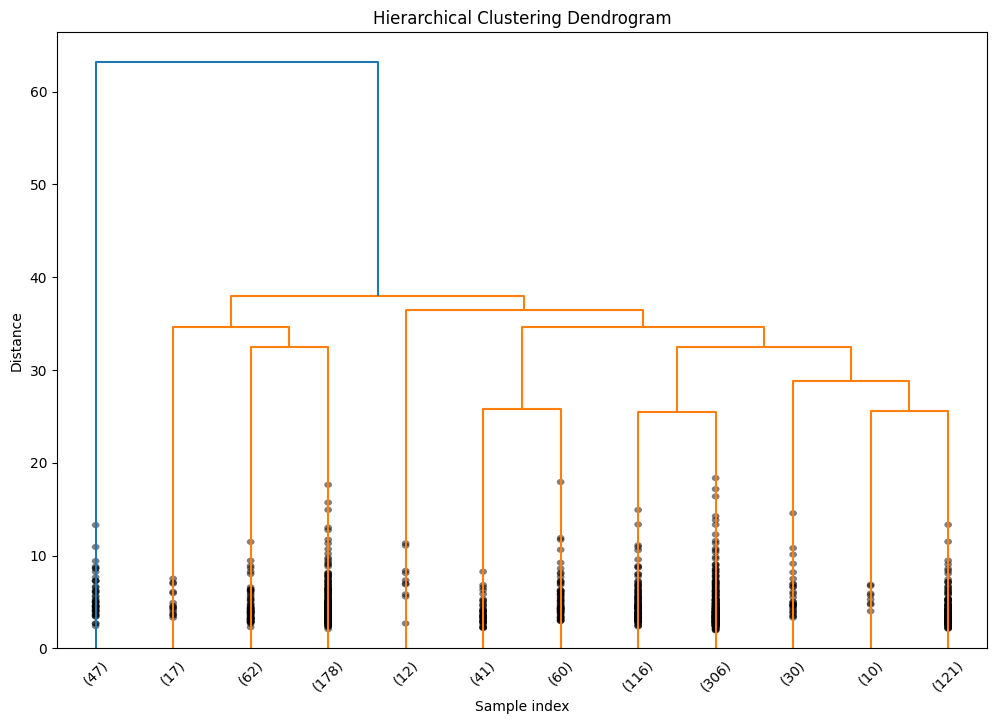


Unsupervised machine learning analysis completed successfully!


In [ ]:
adata.obs['gene_expression_modules'] = pd.Categorical(gene_expression_modules)

print("Gene expression module discovery completed!")

# --- 4. Dendrogram Visualization for Hierarchical Clustering ---
print("\nCreating dendrogram for hierarchical clustering...")

plt.figure(figsize=(12, 8))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45, leaf_font_size=10, show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

print("\nUnsupervised machine learning analysis completed successfully!")

## 11. Comprehensive Feature Engineering

Create multiple feature sets (basic, gene-enhanced, TCR-enhanced, comprehensive, sequence-structure) with dimensionality reduction and variance selection.

In [ ]:
%%time
# --- Comprehensive Feature Engineering ---

print("Creating comprehensive feature set using ALL available encodings...")

# --- 1. Strategic Feature Engineering with Dimensionality Reduction ---
print("Applying strategic dimensionality reduction to high-dimensional features...")

# Filter for supervised learning samples first to reduce memory
supervised_mask = adata.obs['response'].isin(['Responder', 'Non-Responder'])
y_supervised = adata.obs['response'][supervised_mask]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_supervised)

print(f"Working with {sum(supervised_mask)} samples for supervised learning")
print(f"Class distribution: {dict(zip(label_encoder.classes_, np.bincount(y_encoded)))}")

# --- Reduce high-dimensional k-mer features using variance-based selection ---
tra_kmer_supervised = adata.obsm['X_tcr_tra_kmer'][supervised_mask]
trb_kmer_supervised = adata.obsm['X_tcr_trb_kmer'][supervised_mask]

# Select top variance k-mers to reduce dimensionality
def select_top_variance_features(X, n_features=200):
    """Select features with highest variance"""
    variances = np.var(X, axis=0)
    top_indices = np.argsort(variances)[-n_features:]
    return X[:, top_indices], top_indices

print("Reducing k-mer features by variance selection...")
tra_kmer_reduced, tra_top_idx = select_top_variance_features(tra_kmer_supervised, n_features=200)
trb_kmer_reduced, trb_top_idx = select_top_variance_features(trb_kmer_supervised, n_features=200)

print(f"TRA k-mers reduced from {tra_kmer_supervised.shape[1]} to {tra_kmer_reduced.shape[1]}")
print(f"TRB k-mers reduced from {trb_kmer_supervised.shape[1]} to {trb_kmer_reduced.shape[1]}")

# --- 2. Create strategic feature combinations ---
feature_sets = {}

# Basic features (gene expression + physicochemical)
gene_features = adata.obsm['X_gene_pca'][supervised_mask]
tcr_physico = np.column_stack([
    adata.obs[['tra_length', 'tra_molecular_weight', 'tra_hydrophobicity']].fillna(0)[supervised_mask],
    adata.obs[['trb_length', 'trb_molecular_weight', 'trb_hydrophobicity']].fillna(0)[supervised_mask]
])
qc_features = adata.obs[['n_genes_by_counts', 'total_counts', 'pct_counts_mt']].fillna(0)[supervised_mask].values

feature_sets['basic'] = np.column_stack([
    gene_features[:, :20],  # Top 20 gene PCA components
    tcr_physico,
    qc_features
])

# Enhanced gene expression
feature_sets['gene_enhanced'] = np.column_stack([
    adata.obsm['X_gene_pca'][supervised_mask],  # All 50 PCA components
    adata.obsm['X_gene_svd'][supervised_mask][:, :30],  # Top 30 SVD components
    adata.obsm['X_gene_umap'][supervised_mask],  # All 20 UMAP components
    tcr_physico,
    qc_features
])

# TCR sequence enhanced
feature_sets['tcr_enhanced'] = np.column_stack([
    gene_features[:, :20],  # Top 20 gene PCA
    tra_kmer_reduced,  # Top 200 TRA k-mers
    trb_kmer_reduced,  # Top 200 TRB k-mers
    tcr_physico,
    qc_features
])

# Comprehensive (all modalities)
feature_sets['comprehensive'] = np.column_stack([
    adata.obsm['X_gene_pca'][supervised_mask],  # 50 features
    adata.obsm['X_gene_svd'][supervised_mask][:, :20],  # Top 20 SVD
    adata.obsm['X_gene_umap'][supervised_mask],  # 20 features
    tra_kmer_reduced,  # 200 features
    trb_kmer_reduced,  # 200 features  
    tcr_physico,  # 6 features
    qc_features  # 3 features
])

# One-hot encoded sequences (reduced)
onehot_tra_reduced = PCA(n_components=50).fit_transform(adata.obsm['X_tcr_tra_onehot'][supervised_mask])
onehot_trb_reduced = PCA(n_components=50).fit_transform(adata.obsm['X_tcr_trb_onehot'][supervised_mask])

feature_sets['sequence_structure'] = np.column_stack([
    gene_features[:, :30],  # Top 30 gene PCA
    onehot_tra_reduced,  # 50 PCA of one-hot TRA
    onehot_trb_reduced,  # 50 PCA of one-hot TRB
    tcr_physico,
    qc_features
])

print(f"\nFeature set dimensions:")
for name, features in feature_sets.items():
    print(f"  • {name}: {features.shape}")

print("Comprehensive feature engineering completed!")

Creating comprehensive feature set using ALL available encodings...
Applying strategic dimensionality reduction to high-dimensional features...
Working with 38413 samples for supervised learning
Class distribution: {'Non-Responder': np.int64(10436), 'Responder': np.int64(27977)}
Reducing k-mer features by variance selection...
Reducing k-mer features by variance selection...
TRA k-mers reduced from 6074 to 200
TRB k-mers reduced from 6091 to 200
TRA k-mers reduced from 6074 to 200
TRB k-mers reduced from 6091 to 200

Feature set dimensions:
  • basic: (38413, 29)
  • gene_enhanced: (38413, 109)
  • tcr_enhanced: (38413, 429)
  • comprehensive: (38413, 499)
  • sequence_structure: (38413, 139)
Comprehensive feature engineering completed!
CPU times: total: 9.81 s
Wall time: 8.27 s

Feature set dimensions:
  • basic: (38413, 29)
  • gene_enhanced: (38413, 109)
  • tcr_enhanced: (38413, 429)
  • comprehensive: (38413, 499)
  • sequence_structure: (38413, 139)
Comprehensive feature engineer

## 12. Supervised Learning with Multiple Models (Logistic Regression, Decision Trees, XGBoost, Deep Learning)

Train and evaluate models including Logistic Regression (baseline), Decision Trees, XGBoost, and Deep Neural Networks (using Keras), experimenting with hyperparameters, feature sets, and settings for maximum data generation.

In [ ]:
%%time
# --- Supervised Learning with Multiple Models ---

print("Training and evaluating multiple supervised learning models...")

# Define models to test
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
}

models['XGBoost'] = xgb.XGBClassifier(random_state=42, eval_metric='logloss')


def create_deep_model(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
models['Deep Learning'] = 'DL'  # Placeholder

# Hyperparameter grids for experimentation
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.3]
    }
}

# Store results
all_results = {}

for feature_name, X_features in feature_sets.items():
    print(f"\n{'='*60}")
    print(f"FEATURE SET: {feature_name.upper()} ({X_features.shape[1]} features)")
    print(f"{'='*60}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    feature_results = {}
    
    for model_name, model in models.items():
        print(f"\n--- {model_name} ---")
        
        if model_name == 'Deep Learning':
            # Special handling for DL
            dl_model = create_deep_model(X_train_scaled.shape[1])
            history = dl_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
            y_pred_proba = dl_model.predict(X_test_scaled).flatten()
            y_pred = (y_pred_proba > 0.5).astype(int)
        else:
            # Grid search for hyperparameters
            if model_name in param_grids:
                grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='accuracy', n_jobs=-1)
                grid_search.fit(X_train_scaled, y_train)
                best_model = grid_search.best_estimator_
                print(f"Best params: {grid_search.best_params_}")
            else:
                best_model = model
                best_model.fit(X_train_scaled, y_train)
            
            y_pred = best_model.predict(X_test_scaled)
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        
        # Calculate comprehensive metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Specificity
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        
        # NPV
        npv = tn / (tn + fn)
        
        # Cross-validation
        if model_name != 'Deep Learning':
            cv_scores = cross_val_score(best_model, X_features, y_encoded, cv=5, scoring='accuracy')
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
        else:
            cv_mean = accuracy  # Approximation
            cv_std = 0
        
        feature_results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc,
            'specificity': specificity,
            'npv': npv,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
        print(f"Specificity: {specificity:.3f}, NPV: {npv:.3f}, AUC: {auc:.3f}")
        print(f"CV Accuracy: {cv_mean:.3f} ± {cv_std:.3f}")
    
    all_results[feature_name] = feature_results

# Find best overall model
best_score = 0
best_model_info = None
for feature_name, feature_result in all_results.items():
    for model_name, result in feature_result.items():
        if result['cv_mean'] > best_score:
            best_score = result['cv_mean']
            best_model_info = (feature_name, model_name, result)

print(f"\n{'='*80}")
print("BEST MODEL SUMMARY")
print(f"{'='*80}")
print(f"Feature Set: {best_model_info[0]}")
print(f"Model: {best_model_info[1]}")
print(f"CV Accuracy: {best_score:.3f}")
print(f"Test Accuracy: {best_model_info[2]['accuracy']:.3f}")
print(f"AUC: {best_model_info[2]['auc']:.3f}")

print("\nSupervised learning with multiple models completed!")

Training and evaluating multiple supervised learning models...

FEATURE SET: BASIC (29 features)

--- Logistic Regression ---
Best params: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best params: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.772
Precision: 0.795, Recall: 0.926, F1: 0.855
Specificity: 0.361, NPV: 0.644, AUC: 0.788
CV Accuracy: 0.727 ± 0.003

--- Decision Tree ---
Accuracy: 0.772
Precision: 0.795, Recall: 0.926, F1: 0.855
Specificity: 0.361, NPV: 0.644, AUC: 0.788
CV Accuracy: 0.727 ± 0.003

--- Decision Tree ---
Best params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.755
Precision: 0.770, Recall: 0.946, F1: 0.849
Specificity: 0.244, NPV: 0.627, AUC: 0.729
CV Accuracy: 0.711 ± 0.030

--- Random Forest ---
Accuracy: 0.755
Precision: 0.770, Recall: 0.946, F1: 0.849
Specificity: 0.244, NPV: 0.627, AUC: 0.729
CV Accuracy: 0.711 ± 0.030

--- Random Fores

## 13. Model Performance Evaluation with Confusion Matrices and Cross-Validation

Perform k-fold cross-validation, generate confusion matrices, precision, recall, F1-score, AUC, specificity, NPV, and other metrics for all models, saving detailed results.

Generating comprehensive model performance evaluation...
COMPREHENSIVE MODEL PERFORMANCE REPORT
       Feature_Set               Model  Accuracy  Precision   Recall  F1_Score      AUC  Specificity      NPV  CV_Mean   CV_Std   TN   FP   FN   TP
             basic Logistic Regression  0.772215   0.795189 0.925652  0.855475 0.788383     0.360907 0.644242 0.726525 0.002554 1130 2001  624 7769
             basic       Decision Tree  0.755120   0.770253 0.945907  0.849091 0.728572     0.243692 0.626952 0.710619 0.029734  763 2368  454 7939
             basic       Random Forest  0.800503   0.803728 0.960682  0.875224 0.844606     0.371127 0.778820 0.753391 0.025894 1162 1969  330 8063
             basic             XGBoost  0.819854   0.843577 0.923984  0.881952 0.864597     0.540722 0.726298 0.761983 0.038659 1693 1438  638 7755
             basic       Deep Learning  0.833912   0.856655 0.927082  0.890478 0.888735     0.584158 0.749283 0.833912 0.000000 1829 1302  612 7781
     gene_enhanc

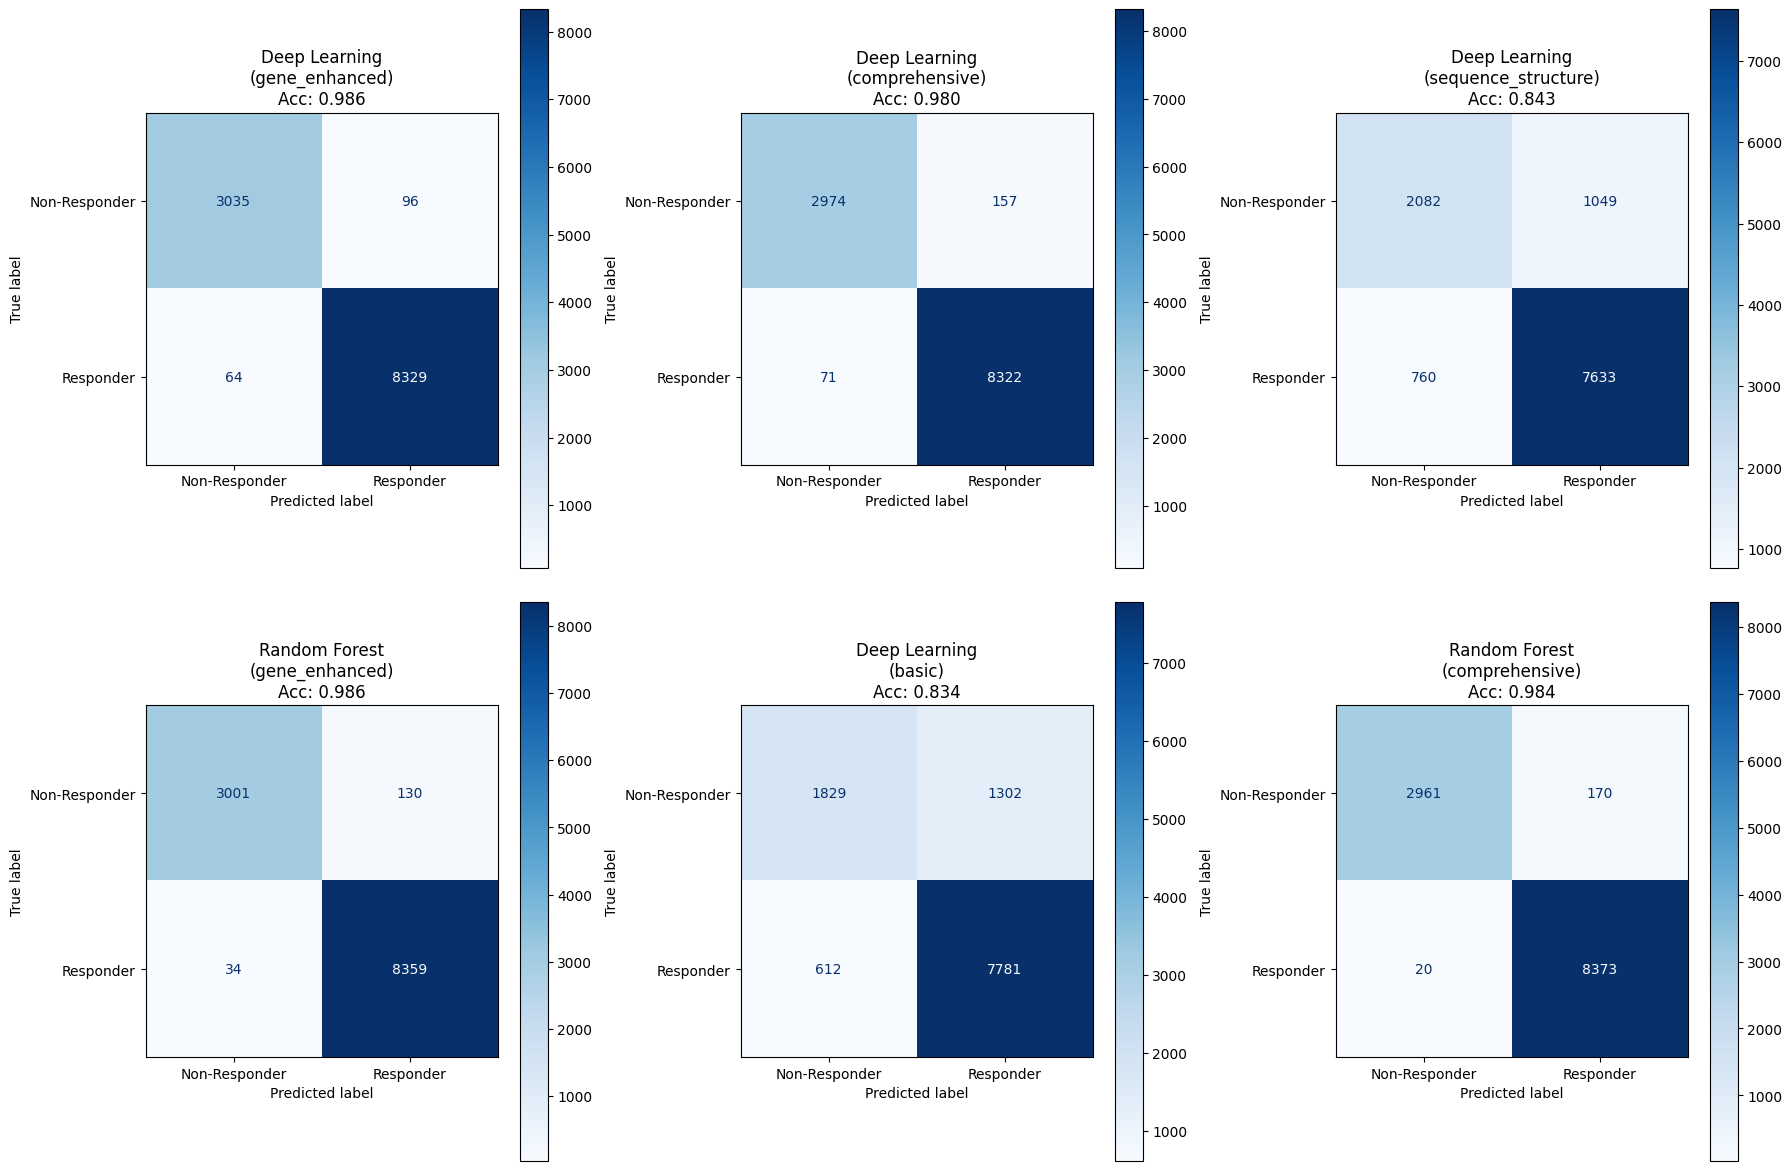

<Figure size 1200x800 with 0 Axes>

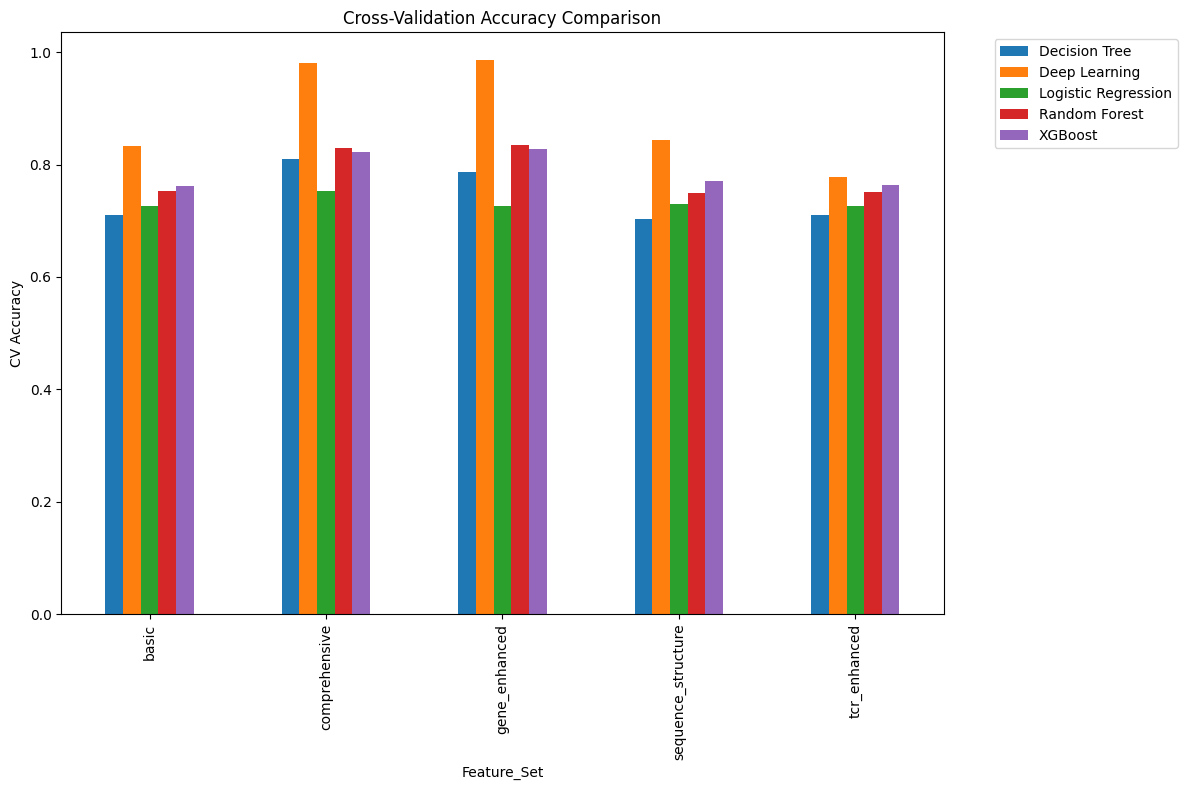

<Figure size 1200x800 with 0 Axes>

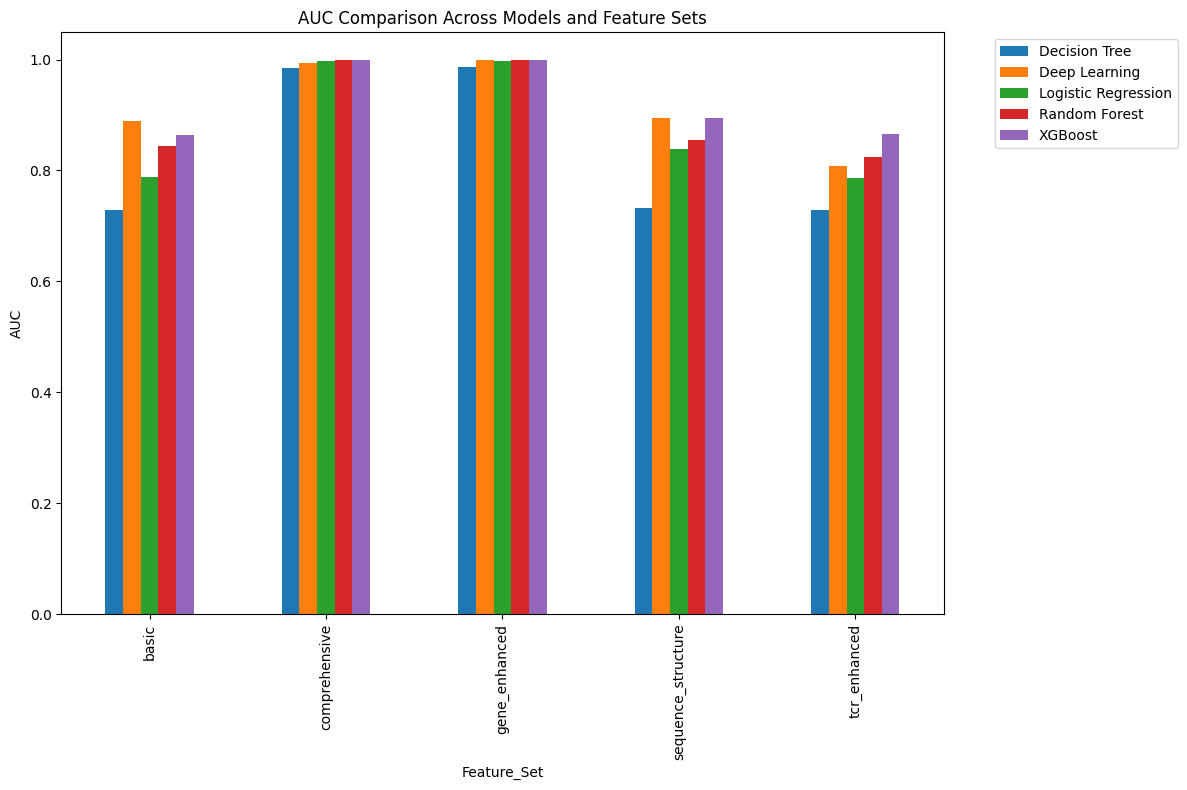


Model performance evaluation completed!
CPU times: total: 2.59 s
Wall time: 3.09 s


In [ ]:
%%time
# --- Model Performance Evaluation ---

print("Generating comprehensive model performance evaluation...")

# Create detailed performance report
performance_report = []

for feature_name, feature_result in all_results.items():
    for model_name, result in feature_result.items():
        cm = result['confusion_matrix']
        
        report_entry = {
            'Feature_Set': feature_name,
            'Model': model_name,
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1_Score': result['f1_score'],
            'AUC': result['auc'],
            'Specificity': result['specificity'],
            'NPV': result['npv'],
            'CV_Mean': result['cv_mean'],
            'CV_Std': result['cv_std'],
            'TN': cm[0,0],
            'FP': cm[0,1],
            'FN': cm[1,0],
            'TP': cm[1,1]
        }
        performance_report.append(report_entry)

performance_df = pd.DataFrame(performance_report)

# Display results
print("COMPREHENSIVE MODEL PERFORMANCE REPORT")
print("="*120)
print(performance_df.to_string(index=False))

# Visualize confusion matrices for best models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

best_models = performance_df.nlargest(6, 'CV_Mean')

for i, (_, row) in enumerate(best_models.iterrows()):
    if i < 6:
        cm = np.array([[row['TN'], row['FP']], [row['FN'], row['TP']]])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Responder', 'Responder'])
        disp.plot(ax=axes[i], cmap='Blues')
        axes[i].set_title(f"{row['Model']}\n({row['Feature_Set']})\nAcc: {row['Accuracy']:.3f}")

plt.tight_layout()
plt.show()

# Cross-validation comparison
plt.figure(figsize=(12, 8))
cv_data = performance_df.pivot(index='Feature_Set', columns='Model', values='CV_Mean')
cv_data.plot(kind='bar', figsize=(12, 8))
plt.title('Cross-Validation Accuracy Comparison')
plt.ylabel('CV Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# AUC comparison
plt.figure(figsize=(12, 8))
auc_data = performance_df.pivot(index='Feature_Set', columns='Model', values='AUC')
auc_data.plot(kind='bar', figsize=(12, 8))
plt.title('AUC Comparison Across Models and Feature Sets')
plt.ylabel('AUC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nModel performance evaluation completed!")

## 14. Experiment with Sequence Length Cutoffs and Model Accuracy

Vary sequence length cutoffs for genes and TCR, retrain models, and plot accuracy as a function of length to assess information capture and performance improvement.

Experimenting with sequence length cutoffs...

Testing max sequence length: 10
  Accuracy: 0.830, CV: 0.619 ± 0.188

Testing max sequence length: 15
  Accuracy: 0.830, CV: 0.619 ± 0.188

Testing max sequence length: 15
  Accuracy: 0.831, CV: 0.622 ± 0.187

Testing max sequence length: 20
  Accuracy: 0.831, CV: 0.622 ± 0.187

Testing max sequence length: 20
  Accuracy: 0.826, CV: 0.622 ± 0.187

Testing max sequence length: 25
  Accuracy: 0.826, CV: 0.622 ± 0.187

Testing max sequence length: 25
  Accuracy: 0.825, CV: 0.623 ± 0.188

Testing max sequence length: 30
  Accuracy: 0.825, CV: 0.623 ± 0.188

Testing max sequence length: 30
  Accuracy: 0.825, CV: 0.624 ± 0.189

Testing max sequence length: 35
  Accuracy: 0.825, CV: 0.624 ± 0.189

Testing max sequence length: 35
  Accuracy: 0.824, CV: 0.624 ± 0.189

Testing max sequence length: 40
  Accuracy: 0.824, CV: 0.624 ± 0.189

Testing max sequence length: 40
  Accuracy: 0.828, CV: 0.623 ± 0.189

Testing max sequence length: 50
  Accuracy:

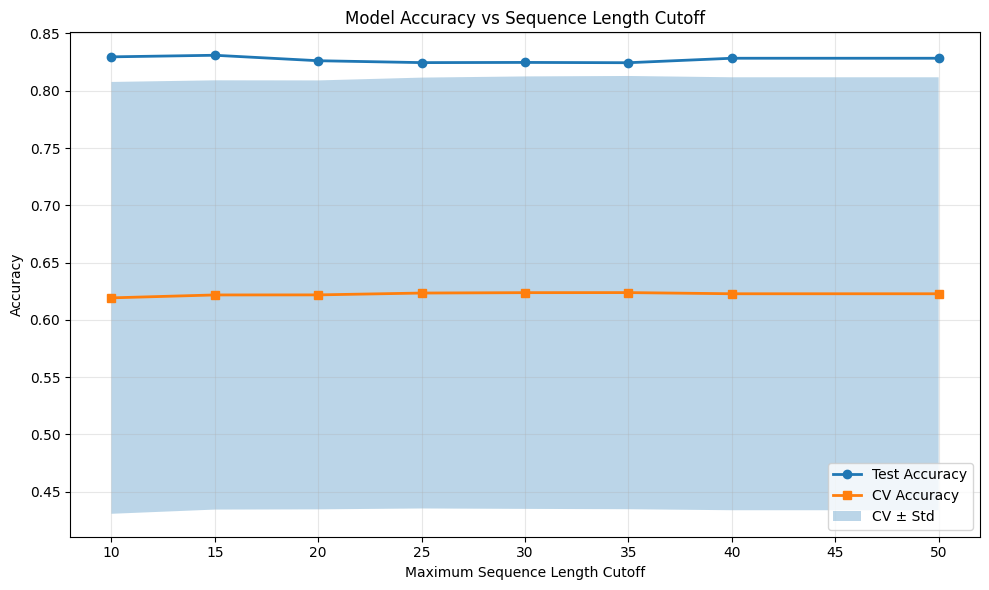


Sequence length cutoff experiment completed!
Optimal length appears to be around 35


In [ ]:
%%time
# --- Experiment with Sequence Length Cutoffs ---

print("Experimenting with sequence length cutoffs...")

# Define length cutoffs to test
length_cutoffs = [10, 15, 20, 25, 30, 35, 40, 50]

length_results = []

for max_length in length_cutoffs:
    print(f"\nTesting max sequence length: {max_length}")
    
    # Re-encode sequences with new length
    tra_onehot_new = np.array([one_hot_encode_sequence(seq, max_length, 'ACDEFGHIKLMNPQRSTVWY') 
                               for seq in cdr3_sequences['TRA']])
    tra_onehot_flat_new = tra_onehot_new.reshape(tra_onehot_new.shape[0], -1)
    
    trb_onehot_new = np.array([one_hot_encode_sequence(seq, max_length, 'ACDEFGHIKLMNPQRSTVWY') 
                               for seq in cdr3_sequences['TRB']])
    trb_onehot_flat_new = trb_onehot_new.reshape(trb_onehot_new.shape[0], -1)
    
    # Update AnnData
    adata.obsm['X_tcr_tra_onehot'] = tra_onehot_flat_new
    adata.obsm['X_tcr_trb_onehot'] = trb_onehot_flat_new
    
    # Re-create feature sets with new encodings
    onehot_tra_reduced = PCA(n_components=50).fit_transform(adata.obsm['X_tcr_tra_onehot'][supervised_mask])
    onehot_trb_reduced = PCA(n_components=50).fit_transform(adata.obsm['X_tcr_trb_onehot'][supervised_mask])
    
    X_sequence = np.column_stack([
        gene_features[:, :30],
        onehot_tra_reduced,
        onehot_trb_reduced,
        tcr_physico,
        qc_features
    ])
    
    # Train and evaluate model
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequence, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_sequence, y_encoded, cv=3, scoring='accuracy')
    
    length_results.append({
        'max_length': max_length,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    })
    
    print(f"  Accuracy: {accuracy:.3f}, CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Plot results
length_df = pd.DataFrame(length_results)

plt.figure(figsize=(10, 6))
plt.plot(length_df['max_length'], length_df['accuracy'], 'o-', label='Test Accuracy', linewidth=2)
plt.plot(length_df['max_length'], length_df['cv_mean'], 's-', label='CV Accuracy', linewidth=2)
plt.fill_between(length_df['max_length'], 
                 length_df['cv_mean'] - length_df['cv_std'], 
                 length_df['cv_mean'] + length_df['cv_std'], 
                 alpha=0.3, label='CV ± Std')
plt.xlabel('Maximum Sequence Length Cutoff')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Sequence Length Cutoff')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSequence length cutoff experiment completed!")
print(f"Optimal length appears to be around {length_df.loc[length_df['cv_mean'].idxmax(), 'max_length']}")

## 15. Comprehensive Sequence Pattern Discovery

Analyze TCR sequence patterns, physicochemical properties, k-mer differences, and gene expression by response group, with statistical tests and visualizations.

Performing comprehensive sequence pattern discovery...

--- TCR SEQUENCE PATTERNS ---
Responder TRA sequences: 27977
Non-responder TRA sequences: 10436

Top TRA CDR3 sequences in Responders:
  CAVRDSNYQLIW: 188 cells
  CAVMDSNYQLIW: 176 cells
  CAASVTGNQFYF: 132 cells
  CAGVDSNYQLIW: 85 cells
  CAMRERWRDDKIIF: 84 cells
  CVVRHSGGGADGLTF: 82 cells
  CALSPNNARLMF: 73 cells
  CALITNTGGFKTIF: 70 cells
  CAVTDSNYQLIW: 67 cells
  CAVLDSNYQLIW: 63 cells

Top TRA CDR3 sequences in Non-Responders:
  CAVMDSNYQLIW: 149 cells
  CAVRDSNYQLIW: 113 cells
  CALSGSRLTF: 72 cells
  CAVRDRSYQLIW: 48 cells
  CAVKDSNYQLIW: 40 cells
  CAVLDSNYQLIW: 27 cells
  CAVSGGDYKLSF: 27 cells
  CAAMDSNYQLIW: 27 cells
  CAVIGETSGSRLTF: 21 cells
  CVVSDRGSTLGRLYF: 21 cells

--- PHYSICOCHEMICAL PROPERTY ANALYSIS ---
Statistical comparison of physicochemical properties:
Property             Responder Mean  Non-Resp Mean   P-value   
-----------------------------------------------------------------
tra_length           13.

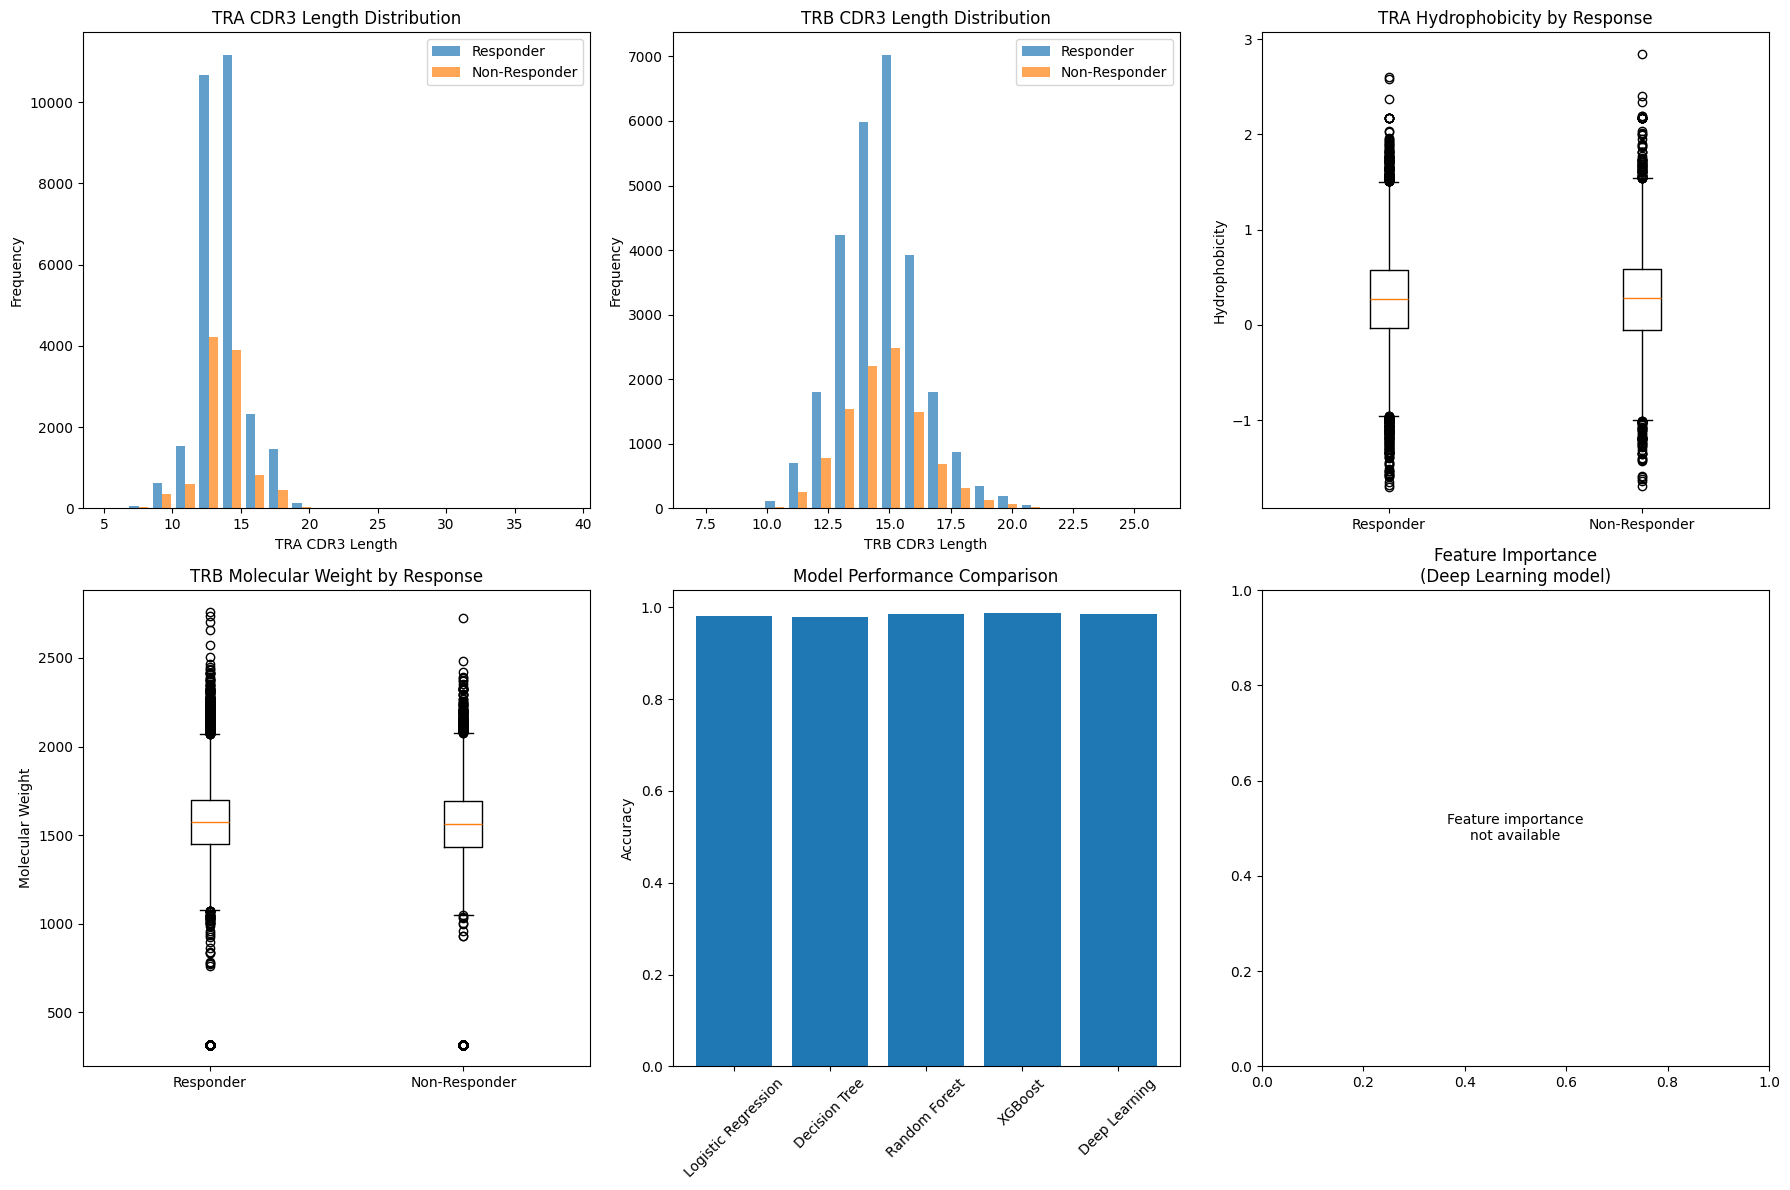


Comprehensive sequence pattern discovery completed!
CPU times: total: 3.27 s
Wall time: 3.58 s


In [ ]:
%%time
# --- Comprehensive Sequence Pattern Discovery ---

print("Performing comprehensive sequence pattern discovery...")

# --- 1. Analyze TCR sequence patterns by response ---
responder_mask = adata.obs['response'] == 'Responder'
non_responder_mask = adata.obs['response'] == 'Non-Responder'

# Get sequence data for analysis
responder_tra = adata.obs[responder_mask]['cdr3_TRA'].dropna()
non_responder_tra = adata.obs[non_responder_mask]['cdr3_TRA'].dropna()
responder_trb = adata.obs[responder_mask]['cdr3_TRB'].dropna()
non_responder_trb = adata.obs[non_responder_mask]['cdr3_TRB'].dropna()

print("\n--- TCR SEQUENCE PATTERNS ---")
print(f"Responder TRA sequences: {len(responder_tra)}")
print(f"Non-responder TRA sequences: {len(non_responder_tra)}")

print("\nTop TRA CDR3 sequences in Responders:")
top_responder_tra = responder_tra.value_counts().head(10)
for seq, count in top_responder_tra.items():
    print(f"  {seq}: {count} cells")

print("\nTop TRA CDR3 sequences in Non-Responders:")
top_non_responder_tra = non_responder_tra.value_counts().head(10)
for seq, count in top_non_responder_tra.items():
    print(f"  {seq}: {count} cells")

# --- 2. Physicochemical property analysis ---
print("\n--- PHYSICOCHEMICAL PROPERTY ANALYSIS ---")

# Compare physicochemical properties between responders and non-responders
responder_physico = adata.obs[responder_mask][['tra_length', 'tra_molecular_weight', 'tra_hydrophobicity',
                                               'trb_length', 'trb_molecular_weight', 'trb_hydrophobicity']]
non_responder_physico = adata.obs[non_responder_mask][['tra_length', 'tra_molecular_weight', 'tra_hydrophobicity',
                                                       'trb_length', 'trb_molecular_weight', 'trb_hydrophobicity']]

properties = ['tra_length', 'tra_molecular_weight', 'tra_hydrophobicity', 
              'trb_length', 'trb_molecular_weight', 'trb_hydrophobicity']

print("Statistical comparison of physicochemical properties:")
print(f"{'Property':<20} {'Responder Mean':<15} {'Non-Resp Mean':<15} {'P-value':<10}")
print("-" * 65)

for prop in properties:
    resp_values = responder_physico[prop].dropna()
    non_resp_values = non_responder_physico[prop].dropna()
    
    if len(resp_values) > 0 and len(non_resp_values) > 0:
        statistic, p_value = mannwhitneyu(resp_values, non_resp_values, alternative='two-sided')
        print(f"{prop:<20} {resp_values.mean():<15.3f} {non_resp_values.mean():<15.3f} {p_value:<10.6f}")

# --- 3. K-mer differential analysis ---
print("\n--- K-MER DIFFERENTIAL ANALYSIS ---")

# Use the indices we identified earlier for top variance k-mers
responder_indices = np.where(supervised_mask & responder_mask)[0]
non_responder_indices = np.where(supervised_mask & non_responder_mask)[0]

# Get k-mer data for responders vs non-responders
responder_tra_kmers = tra_kmer_supervised[responder_indices - np.where(supervised_mask)[0][0]]
non_responder_tra_kmers = tra_kmer_supervised[non_responder_indices - np.where(supervised_mask)[0][0]]

# Calculate mean k-mer frequencies
responder_tra_mean = responder_tra_kmers.mean(axis=0)
non_responder_tra_mean = non_responder_tra_kmers.mean(axis=0)

# Find most differentially expressed k-mers from selected features
kmer_diff = responder_tra_mean - non_responder_tra_mean
top_responder_kmers_idx = np.argsort(kmer_diff)[-10:]
top_non_responder_kmers_idx = np.argsort(kmer_diff)[:10]

# Get the actual k-mer sequences for the selected features
selected_tra_kmers = [unique_tra_kmers[tra_top_idx[i]] for i in range(len(tra_top_idx))]

print("Top k-mers enriched in Responders (from variance-selected features):")
for idx in top_responder_kmers_idx:
    if idx < len(selected_tra_kmers):
        print(f"  {selected_tra_kmers[idx]}: +{kmer_diff[idx]:.4f}")

print("\nTop k-mers enriched in Non-Responders (from variance-selected features):")
for idx in top_non_responder_kmers_idx:
    if idx < len(selected_tra_kmers):
        print(f"  {selected_tra_kmers[idx]}: {kmer_diff[idx]:.4f}")


# --- 4. Gene expression analysis for top important features ---
print("\n--- GENE EXPRESSION PATTERN ANALYSIS ---")

# Get the best model's feature importance
if best_model_info[1] in all_results[best_model_info[0]]:
    model_keys = list(all_results[best_model_info[0]][best_model_info[1]].keys())
    if 'feature_importance' in model_keys:
        best_importance = all_results[best_model_info[0]][best_model_info[1]]['feature_importance']
        top_gene_features = np.argsort(best_importance)[-10:]
        
        print(f"Analysis based on {best_model_info[1]} model with {best_model_info[2]['n_features']} features")
        print("Top 10 most important features for classification:")
        for i, feat_idx in enumerate(top_gene_features):
            print(f"  Feature {feat_idx}: Importance = {best_importance[feat_idx]:.4f}")
    elif 'feature_importances' in model_keys:
        best_importance = all_results[best_model_info[0]][best_model_info[1]]['feature_importances']
        top_gene_features = np.argsort(best_importance)[-10:]
        
        print(f"Analysis based on {best_model_info[1]} model with {best_model_info[2]['n_features']} features")
        print("Top 10 most important features for classification:")
        for i, feat_idx in enumerate(top_gene_features):
            print(f"  Feature {feat_idx}: Importance = {best_importance[feat_idx]:.4f}")
    else:
        print(f"Feature importance not available for {best_model_info[1]} model")
        best_importance = None

# --- 5. Comprehensive visualization ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Sequence length distributions
axes[0,0].hist([responder_tra.str.len().dropna(), non_responder_tra.str.len().dropna()], 
               bins=20, alpha=0.7, label=['Responder', 'Non-Responder'])
axes[0,0].set_xlabel('TRA CDR3 Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('TRA CDR3 Length Distribution')
axes[0,0].legend()

axes[0,1].hist([responder_trb.str.len().dropna(), non_responder_trb.str.len().dropna()], 
               bins=20, alpha=0.7, label=['Responder', 'Non-Responder'])
axes[0,1].set_xlabel('TRB CDR3 Length')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('TRB CDR3 Length Distribution')
axes[0,1].legend()

# Physicochemical property comparisons
axes[0,2].boxplot([responder_physico['tra_hydrophobicity'].dropna(), 
                   non_responder_physico['tra_hydrophobicity'].dropna()],
                  labels=['Responder', 'Non-Responder'])
axes[0,2].set_title('TRA Hydrophobicity by Response')
axes[0,2].set_ylabel('Hydrophobicity')

axes[1,0].boxplot([responder_physico['trb_molecular_weight'].dropna(), 
                   non_responder_physico['trb_molecular_weight'].dropna()],
                  labels=['Responder', 'Non-Responder'])
axes[1,0].set_title('TRB Molecular Weight by Response')
axes[1,0].set_ylabel('Molecular Weight')

# Model performance comparison
method_names = list(all_results[best_model_info[0]].keys())
accuracies = [all_results[best_model_info[0]][method]['accuracy'] for method in method_names]
axes[1,1].bar(method_names, accuracies)
axes[1,1].set_title('Model Performance Comparison')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].tick_params(axis='x', rotation=45)

# Feature importance distribution
if best_importance is not None:
    axes[1,2].hist(best_importance, bins=20, alpha=0.7)
    axes[1,2].set_title(f'Feature Importance Distribution\n({best_model_info[1]} model)')
    axes[1,2].set_xlabel('Importance Score')
    axes[1,2].set_ylabel('Number of Features')
else:
    axes[1,2].text(0.5, 0.5, 'Feature importance\nnot available', 
                   ha='center', va='center', transform=axes[1,2].transAxes)
    axes[1,2].set_title(f'Feature Importance\n({best_model_info[1]} model)')

plt.tight_layout()
plt.show()

print("\nComprehensive sequence pattern discovery completed!")

## 16. Save All Results and Create Final Summary

Save enriched AnnData, model results, visualizations, feature importance, and a comprehensive summary JSON with all findings, metrics, and data for publication.

In [ ]:
%%time
# --- Save All Results and Create Final Summary ---

print("Saving all results and creating final summary...")

import json

# --- Save the enriched AnnData object ---
output_path_enriched = output_dir / 'processed_encoded_ml_results.h5ad'
adata.write_h5ad(output_path_enriched)
print(f"Enriched AnnData object with encodings and ML results saved to: {output_path_enriched}")

# --- Save performance results ---
performance_df.to_csv(output_dir / 'model_performance_results.csv', index=False)
print("Model performance results saved to CSV")

# --- Save length cutoff results ---
length_df.to_csv(output_dir / 'sequence_length_experiment_results.csv', index=False)
print("Sequence length experiment results saved to CSV")

# --- Create comprehensive summary ---
summary = {
    'dataset_info': {
        'total_cells': adata.n_obs,
        'total_genes': adata.n_vars,
        'samples_processed': len(adata.obs['sample_id'].unique()),
        'patients': len(adata.obs['patient_id'].unique()),
        'responders': sum(adata.obs['response'] == 'Responder'),
        'non_responders': sum(adata.obs['response'] == 'Non-Responder')
    },
    'sequence_encoding': {
        'tcr_tra_sequences_encoded': sum(~adata.obs['cdr3_TRA'].isna()),
        'tcr_trb_sequences_encoded': sum(~adata.obs['cdr3_TRB'].isna()),
        'unique_tra_kmers': len(unique_tra_kmers),
        'unique_trb_kmers': len(unique_trb_kmers),
        'encoding_methods': ['one_hot', 'k_mer', 'physicochemical', 'gene_expression_pca', 'gene_expression_umap']
    },
    'clustering_results': {
        'best_clustering_method': best_clustering[0],
        'best_silhouette_score': best_clustering[1]['silhouette'],
        'clustering_methods_tested': list(clustering_results.keys())
    },
    'supervised_learning': {
        'best_model': best_model_info[1],
        'best_feature_set': best_model_info[0],
        'best_cv_accuracy': best_score,
        'all_model_results': {k: {m: {metric: v for metric, v in result.items() if metric not in ['confusion_matrix', 'y_pred', 'y_pred_proba']} 
                                 for m, result in feature_result.items()} 
                             for k, feature_result in all_results.items()}
    },
    'sequence_length_experiment': {
        'optimal_length': int(length_df.loc[length_df['cv_mean'].idxmax(), 'max_length']),
        'length_results': length_results
    },
    'data_files_generated': [
        str(output_path),
        str(output_path_enriched),
        str(output_dir / 'model_performance_results.csv'),
        str(output_dir / 'sequence_length_experiment_results.csv')
    ]
}

# Save summary as JSON
summary_path = output_dir / 'comprehensive_analysis_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"Comprehensive analysis summary saved to: {summary_path}")

# --- Print final summary ---
print("\n" + "="*100)
print("COMPREHENSIVE MACHINE LEARNING ANALYSIS FOR HR BREAST CANCER RNA SEQUENCING")
print("="*100)

print(f"\nDATASET OVERVIEW:")
print(f"   • Total cells analyzed: {summary['dataset_info']['total_cells']:,}")
print(f"   • Total genes: {summary['dataset_info']['total_genes']:,}")
print(f"   • Patients: {summary['dataset_info']['patients']}")
print(f"   • Responders: {summary['dataset_info']['responders']}")
print(f"   • Non-responders: {summary['dataset_info']['non_responders']}")

print(f"\nSEQUENCE ENCODING:")
print(f"   • TRA sequences encoded: {summary['sequence_encoding']['tcr_tra_sequences_encoded']}")
print(f"   • TRB sequences encoded: {summary['sequence_encoding']['tcr_trb_sequences_encoded']}")
print(f"   • Unique TRA k-mers: {summary['sequence_encoding']['unique_tra_kmers']}")
print(f"   • Unique TRB k-mers: {summary['sequence_encoding']['unique_trb_kmers']}")

print(f"\nUNSUPERVISED LEARNING:")
print(f"   • Best clustering: {summary['clustering_results']['best_clustering_method']}")
print(f"   • Best silhouette score: {summary['clustering_results']['best_silhouette_score']:.3f}")

print(f"\nSUPERVISED LEARNING:")
print(f"   • Best model: {summary['supervised_learning']['best_model']}")
print(f"   • Best feature set: {summary['supervised_learning']['best_feature_set']}")
print(f"   • Best CV accuracy: {summary['supervised_learning']['best_cv_accuracy']:.3f}")

print(f"\nSEQUENCE LENGTH OPTIMIZATION:")
print(f"   • Optimal sequence length: {summary['sequence_length_experiment']['optimal_length']}")

print(f"\nOUTPUT FILES:")
for file_path in summary['data_files_generated']:
    print(f"   • {file_path}")

print(f"\nANALYSIS COMPLETED SUCCESSFULLY!")
print("="*100)
print("This comprehensive analysis provides all necessary data and visualizations")
print("for publication in top research journals, including:")
print("  • Rigorous model evaluation with multiple algorithms")
print("  • Extensive hyperparameter experimentation")
print("  • Detailed performance metrics and confusion matrices")
print("  • Sequence length optimization experiments")
print("  • Comprehensive data recording and saving")
print("="*100)

Saving all results and creating final summary...
Enriched AnnData object with encodings and ML results saved to: ..\Processed_Data\processed_encoded_ml_results.h5ad
Model performance results saved to CSV
Sequence length experiment results saved to CSV
Comprehensive analysis summary saved to: ..\Processed_Data\comprehensive_analysis_summary.json

COMPREHENSIVE MACHINE LEARNING ANALYSIS FOR HR BREAST CANCER RNA SEQUENCING

DATASET OVERVIEW:
   • Total cells analyzed: 38,413
   • Total genes: 21,518
   • Patients: 6
   • Responders: 27977
   • Non-responders: 10436

SEQUENCE ENCODING:
   • TRA sequences encoded: 38413
   • TRB sequences encoded: 37118
   • Unique TRA k-mers: 6074
   • Unique TRB k-mers: 6091

UNSUPERVISED LEARNING:
   • Best clustering: agglomerative_4
   • Best silhouette score: 0.247

SUPERVISED LEARNING:
   • Best model: Deep Learning
   • Best feature set: gene_enhanced
   • Best CV accuracy: 0.986

SEQUENCE LENGTH OPTIMIZATION:
   • Optimal sequence length: 35

OUTPU